In [1]:
import ee
ee.Authenticate()            # abrirá una URL; copiá el código de vuelta en la consola
ee.Initialize()              # opcional: ee.Initialize(project='tu-proyecto-gcp')



Successfully saved authorization token.


In [ ]:
import ee
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import unicodedata
from functools import reduce as _reduce

# ================= CONFIG =================
PROVINCES = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

# Rangos: histórico para promedio y año actual (END exclusivo)
RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

# Activar datasets
DO_IMERG = True    # precipitación IMERG 30-min -> diario
DO_ERA5  = True    # temp 2m y precip ERA5-Land diario
DO_LST   = True    # MODIS LST día/noche diario
DO_ET    = False   # MODIS ET 8 días (opcional)
DO_NDVI  = False   # MODIS NDVI 16 días (opcional)

# Escalas para promedios espaciales
SCALE_IMERG = 11000
SCALE_ERA5  = 11000
SCALE_LST   = 1000
SCALE_ET    = 500
SCALE_NDVI  = 250

# Salidas (CSV)
CSV_HIST = "gee_alertas_hist_2017_2024.csv"
CSV_CURR = "gee_alertas_2025.csv"
CSV_ALL  = "gee_alertas_multi_2017_2025.csv"

# ================= INIT =================
ee.Initialize()

# ================= HELPERS =================
def _norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize('NFD', s)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn').lower().strip()

def provinces_fc(names):
    """FC GAUL(AR) con prop 'province' y geometría; match de nombres sin acentos/mayúsculas."""
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("ADM0_NAME", "Argentina"))
    feats = gaul.getInfo()["features"]
    gaul_map = {_norm(f["properties"]["ADM1_NAME"]): f["properties"]["ADM1_NAME"] for f in feats}
    resolved = []
    for n in names:
        k = _norm(n)
        if k in gaul_map: resolved.append(gaul_map[k])
        else: print(f"⚠️ No encontré '{n}' en GAUL.")
    fc = gaul.filter(ee.Filter.inList("ADM1_NAME", resolved))
    fc = fc.map(lambda f: ee.Feature(ee.Feature(f).geometry(), {"province": ee.Feature(f).get("ADM1_NAME")}))
    try:
        print("✅ Provincias GAUL:", ee.FeatureCollection(fc).aggregate_array('province').getInfo())
    except: pass
    return fc

def dates_list(start_str, end_str):
    start = ee.Date(start_str); end = ee.Date(end_str)
    n = end.difference(start, "day").toInt()
    return ee.List.sequence(0, n.subtract(1)).map(lambda k: start.advance(ee.Number(k), "day"))

def month_range(y0, m0, y1, m1):
    cur = datetime(y0, m0, 1); end = datetime(y1, m1, 1); out = []
    while cur <= end:
        nxty = cur.year + (cur.month // 12); nxtm = (cur.month % 12) + 1
        nxt = datetime(nxty, nxtm, 1)
        out.append((cur.strftime('%Y-%m-%d'), nxt.strftime('%Y-%m-%d')))
        cur = nxt
    return out

def fc_to_df(fc, cols_keep):
    feats = ee.FeatureCollection(fc).getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        rows.append({c: p.get(c) for c in cols_keep})
    return pd.DataFrame(rows, columns=cols_keep) if rows else pd.DataFrame(columns=cols_keep)

def reduce_ic_over_provinces(ic, prov_fc, scale, band_map, dataset_name):
    """
    reduceRegions mean sobre provincias para CADA imagen; devuelve FC sin geometría,
    solo con: province, date, dataset y bandas renombradas.
    """
    in_bands  = list(band_map.keys())
    out_bands = list(band_map.values())
    keys_keep = ee.List(out_bands).cat(ee.List(['province', 'date', 'dataset']))

    def per_image(img):
        img = ee.Image(img).select(in_bands, out_bands)
        dstr = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")
        fc = img.reduceRegions(collection=prov_fc, reducer=ee.Reducer.mean(), scale=scale, tileScale=4) \
                .map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(ee.List(out_bands).cat(ee.List(['province']))))
                     .set({'date': dstr, 'dataset': dataset_name}))
        fc = fc.map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(keys_keep)))
        return fc

    return ee.FeatureCollection(ic.map(per_image).flatten())

# ================= DATASET BUILDERS (CHUNK MENSUAL) =================
PROV_FC = provinces_fc(PROVINCES)

def build_imerg_df_month(ms, me):
    ic_30m = ee.ImageCollection("NASA/GPM_L3/IMERG_V07").filterDate(ms, me).select("precipitation")
    days = dates_list(ms, me)
    def daily_image(d):
        d = ee.Date(d)
        day_ic = ic_30m.filterDate(d, d.advance(1, "day"))
        daily = ee.Image(ee.Algorithms.If(day_ic.size().gt(0), day_ic.sum().multiply(0.5), ee.Image.constant(0))) \
                  .rename("imerg_precip_mm").set("system:time_start", d.millis())
        return daily
    daily_ic = ee.ImageCollection(days.map(daily_image))
    fc = reduce_ic_over_provinces(daily_ic, PROV_FC, SCALE_IMERG, {"imerg_precip_mm":"imerg_precip_mm"}, "IMERG")
    return fc_to_df(fc, ["province","date","imerg_precip_mm"])

def build_era5_df_month(ms, me):
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate(ms, me) \
         .select(["temperature_2m", "total_precipitation_sum"])
    def conv(img):
        t2mC = ee.Image(img).select("temperature_2m").subtract(273.15).rename("era5_t2m_C")
        prmm = ee.Image(img).select("total_precipitation_sum").multiply(1000.0).rename("era5_precip_mm")
        return t2mC.addBands(prmm).copyProperties(img, ["system:time_start"])
    ic = ic.map(conv)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ERA5,
                                  {"era5_t2m_C":"era5_t2m_C","era5_precip_mm":"era5_precip_mm"}, "ERA5")
    return fc_to_df(fc, ["province","date","era5_t2m_C","era5_precip_mm"])

def build_lst_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD11A1").filterDate(ms, me) \
         .select(["LST_Day_1km","LST_Night_1km"])
    def toC(img):
        dayC   = ee.Image(img).select("LST_Day_1km").multiply(0.02).subtract(273.15).rename("lst_day_C")
        nightC = ee.Image(img).select("LST_Night_1km").multiply(0.02).subtract(273.15).rename("lst_night_C")
        return dayC.addBands(nightC).copyProperties(img, ["system:time_start"])
    ic = ic.map(toC)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_LST,
                                  {"lst_day_C":"lst_day_C","lst_night_C":"lst_night_C"}, "MODIS_LST")
    return fc_to_df(fc, ["province","date","lst_day_C","lst_night_C"])

def build_et_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD16A2").filterDate(ms, me).select(["ET"]) \
         .map(lambda img: ee.Image(img).multiply(0.1).rename("modis_et_mm_8d")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ET, {"modis_et_mm_8d":"modis_et_mm_8d"}, "MODIS_ET")
    return fc_to_df(fc, ["province","date","modis_et_mm_8d"])

def build_ndvi_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ms, me).select(["NDVI"]) \
         .map(lambda img: ee.Image(img).multiply(0.0001).rename("modis_ndvi")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_NDVI, {"modis_ndvi":"modis_ndvi"}, "MODIS_NDVI")
    return fc_to_df(fc, ["province","date","modis_ndvi"])

def fetch_range_chunked(start_str, end_str):
    """Descarga rango en chunks mensuales por dataset y hace outer-merge por ['province','date']."""
    y0, m0 = int(start_str[:4]), int(start_str[5:7])
    y1, m1 = int(end_str[:4]), int(end_str[5:7])
    months = month_range(y0, m0, y1, m1)

    dfs = []
    if DO_IMERG:
        parts = []
        for ms, me in months:
            print(f"IMERG {ms} → {me}")
            parts.append(build_imerg_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","imerg_precip_mm"]))

    if DO_ERA5:
        parts = []
        for ms, me in months:
            print(f"ERA5 {ms} → {me}")
            parts.append(build_era5_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","era5_t2m_C","era5_precip_mm"]))

    if DO_LST:
        parts = []
        for ms, me in months:
            print(f"LST {ms} → {me}")
            parts.append(build_lst_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))

    if DO_ET:
        parts = []
        for ms, me in months:
            print(f"ET {ms} → {me}")
            parts.append(build_et_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_et_mm_8d"]))

    if DO_NDVI:
        parts = []
        for ms, me in months:
            print(f"NDVI {ms} → {me}")
            parts.append(build_ndvi_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_ndvi"]))

    if not dfs:
        return pd.DataFrame(columns=["province","date"])

    df = _reduce(lambda l, r: pd.merge(l, r, on=["province","date"], how="outer"), dfs)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    # numéricos + precip preferida
    for c in ["imerg_precip_mm","era5_precip_mm","era5_t2m_C","lst_day_C","lst_night_C","modis_et_mm_8d","modis_ndvi"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if {"imerg_precip_mm","era5_precip_mm"}.issubset(df.columns):
        df["precip_mm_pref"] = df["imerg_precip_mm"].fillna(df["era5_precip_mm"])
    elif "era5_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["era5_precip_mm"]
    elif "imerg_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["imerg_precip_mm"]

    return df

# ================= RUN: HISTÓRICO + 2025 (chunk mensual) =================
print("=== Descargando HISTÓRICO ===")
df_hist = fetch_range_chunked(*RANGE_HIST)
print("=== Descargando 2025 ===")
df_2025 = fetch_range_chunked(*RANGE_CURR)

# Guardar CSVs (opcional)
if not df_hist.empty: df_hist.to_csv(CSV_HIST, index=False)
if not df_2025.empty: df_2025.to_csv(CSV_CURR, index=False)

# Unir todo
df_all_multi = pd.concat([df_hist, df_2025], ignore_index=True)
df_all_multi = df_all_multi.drop_duplicates(["province","date"]).sort_values(["province","date"]).reset_index(drop=True)
df_all_multi.to_csv(CSV_ALL, index=False)
print("✅ Guardado:", CSV_ALL, "| Filas:", len(df_all_multi))

# ================= CLIMATOLOGÍA + ANOMALÍAS (ejemplo con precip_mm_pref) =================
df = df_all_multi.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["mmdd"] = df["date"].dt.strftime("%m-%d")
var = "precip_mm_pref"

# Climatología 2017–2024
mask_hist = (df["date"] >= pd.to_datetime(RANGE_HIST[0])) & (df["date"] <= pd.to_datetime(RANGE_HIST[1]))
d_hist = df.loc[mask_hist & df[var].notna()].copy()
d_hist = d_hist[d_hist["mmdd"] != "02-29"]
clim = (d_hist.groupby(["province","mmdd"])[var]
          .agg(mean="mean", std="std", count="count")
          .reset_index())

# Anomalías 2025 vs histórico
d_2025 = df[(df["year"] == 2025) & df[var].notna()].copy()
d_2025 = d_2025[d_2025["mmdd"] != "02-29"]
anom = d_2025.merge(clim, on=["province","mmdd"], how="left", suffixes=("", "_clim"))
anom["anom"] = anom[var] - anom["mean"]
anom["anom_pct"] = np.where(anom["mean"].abs() > 1e-9, 100.0 * anom["anom"] / anom["mean"], np.nan)
anom["zscore"] = (anom["anom"] / anom["std"]).replace([np.inf, -np.inf], np.nan)

print("✅ Climatología filas:", len(clim), "| Anomalías 2025 filas:", len(anom))
print(anom[["province","date",var,"mean","anom","anom_pct","zscore"]].head())


✅ Provincias GAUL: ['Buenos Aires', 'Chaco', 'Cordoba', 'Entre Rios', 'La Pampa', 'Santa Fe']
=== Descargando HISTÓRICO ===
IMERG 2017-01-01 → 2017-02-01
IMERG 2017-02-01 → 2017-03-01
IMERG 2017-03-01 → 2017-04-01
IMERG 2017-04-01 → 2017-05-01
IMERG 2017-05-01 → 2017-06-01
IMERG 2017-06-01 → 2017-07-01
IMERG 2017-07-01 → 2017-08-01
IMERG 2017-08-01 → 2017-09-01
IMERG 2017-09-01 → 2017-10-01
IMERG 2017-10-01 → 2017-11-01
IMERG 2017-11-01 → 2017-12-01
IMERG 2017-12-01 → 2018-01-01
IMERG 2018-01-01 → 2018-02-01
IMERG 2018-02-01 → 2018-03-01
IMERG 2018-03-01 → 2018-04-01
IMERG 2018-04-01 → 2018-05-01
IMERG 2018-05-01 → 2018-06-01
IMERG 2018-06-01 → 2018-07-01
IMERG 2018-07-01 → 2018-08-01


💾 Guardado: plots\precip7_buenos_aires.png


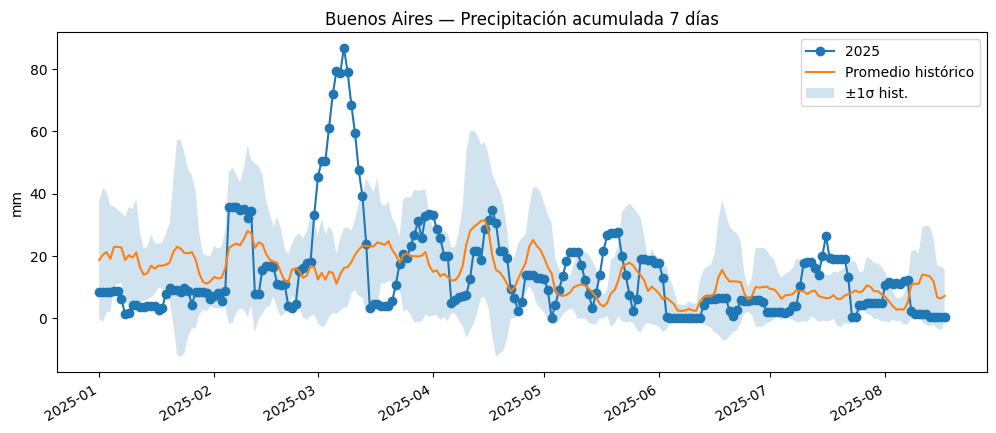

💾 Guardado: plots\precip7_chaco.png


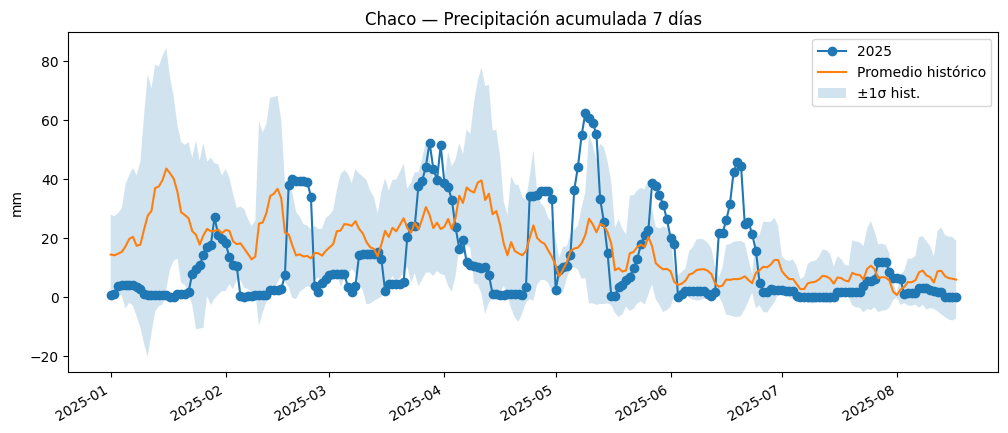

💾 Guardado: plots\precip7_cordoba.png


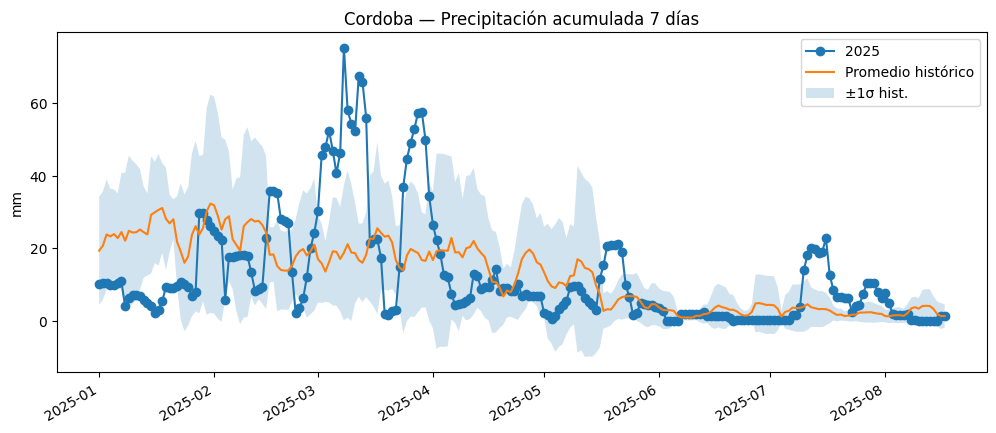

💾 Guardado: plots\precip7_entre_rios.png


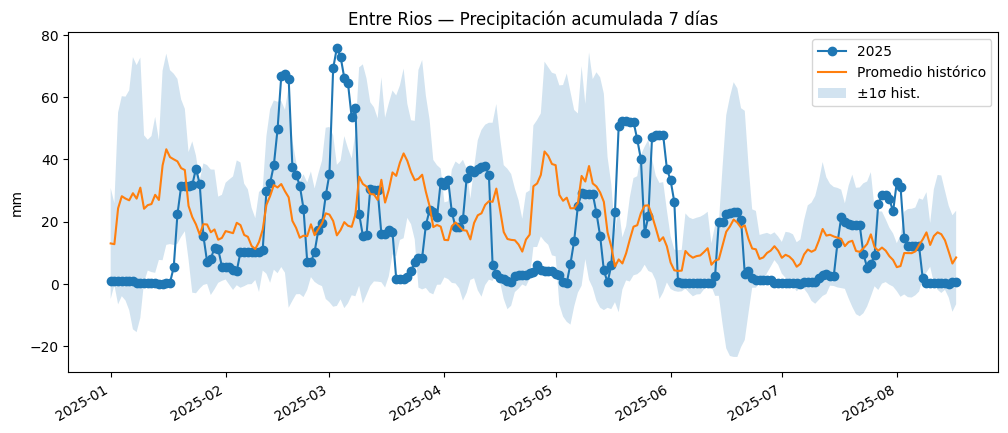

💾 Guardado: plots\precip7_la_pampa.png


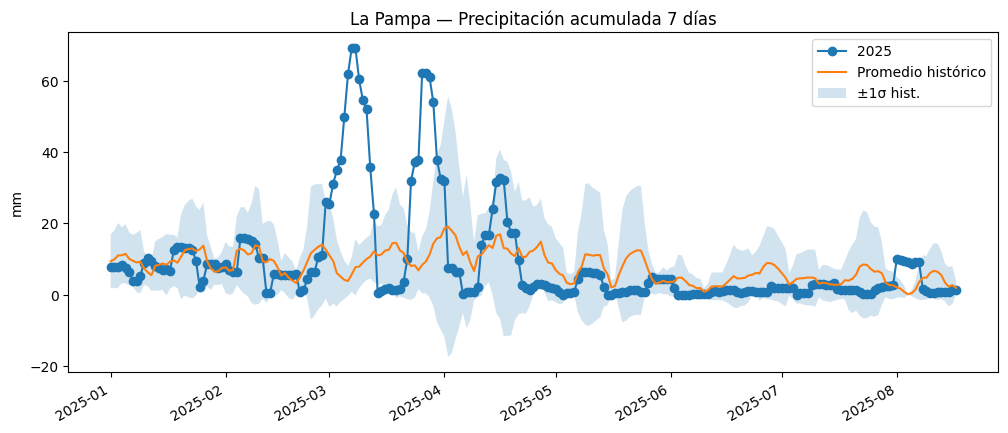

💾 Guardado: plots\precip7_santa_fe.png


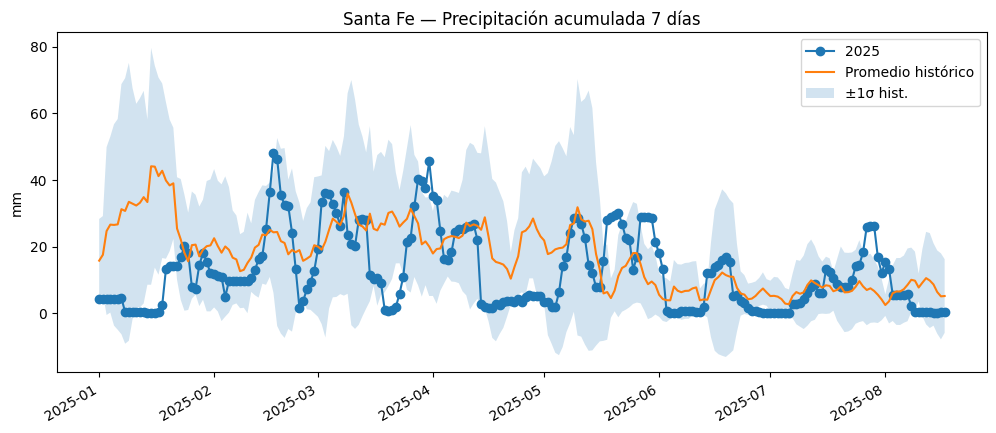

💾 Guardado: plots\t2m7_buenos_aires.png


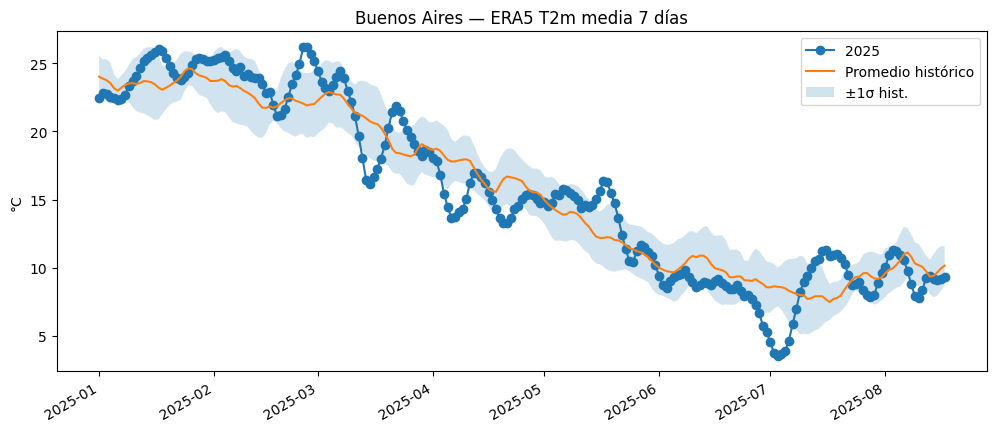

💾 Guardado: plots\t2m7_chaco.png


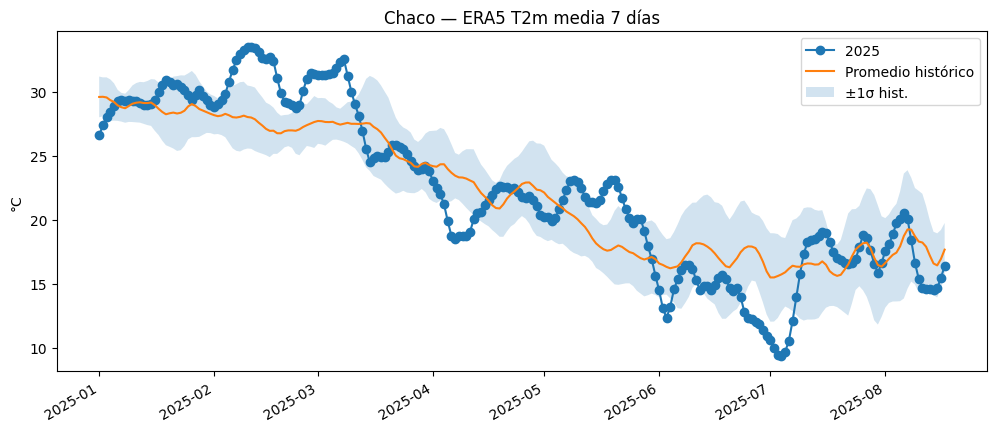

💾 Guardado: plots\t2m7_cordoba.png


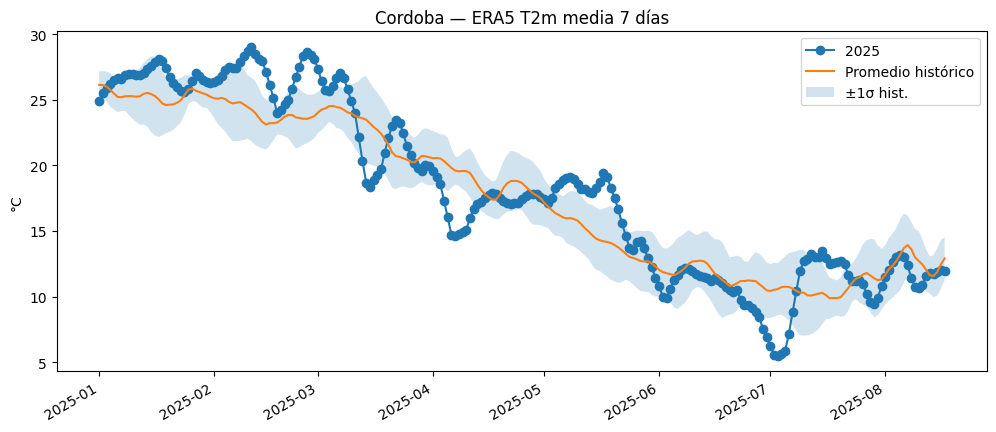

💾 Guardado: plots\t2m7_entre_rios.png


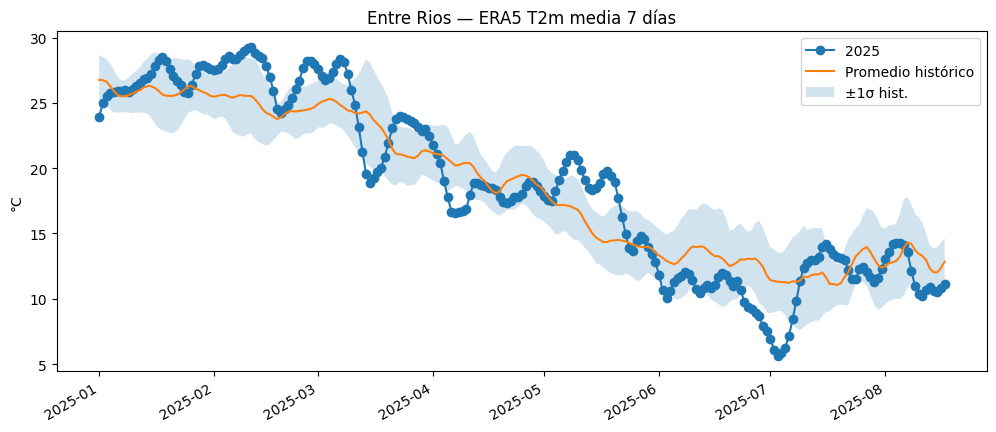

💾 Guardado: plots\t2m7_la_pampa.png


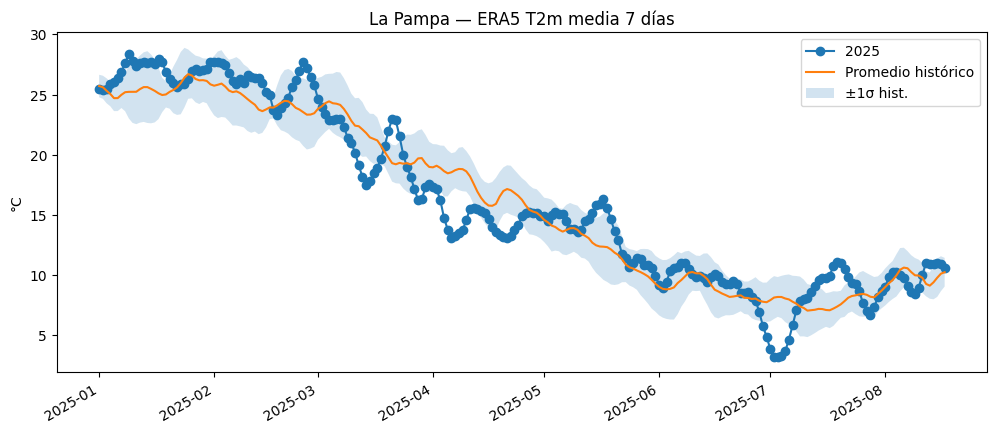

💾 Guardado: plots\t2m7_santa_fe.png


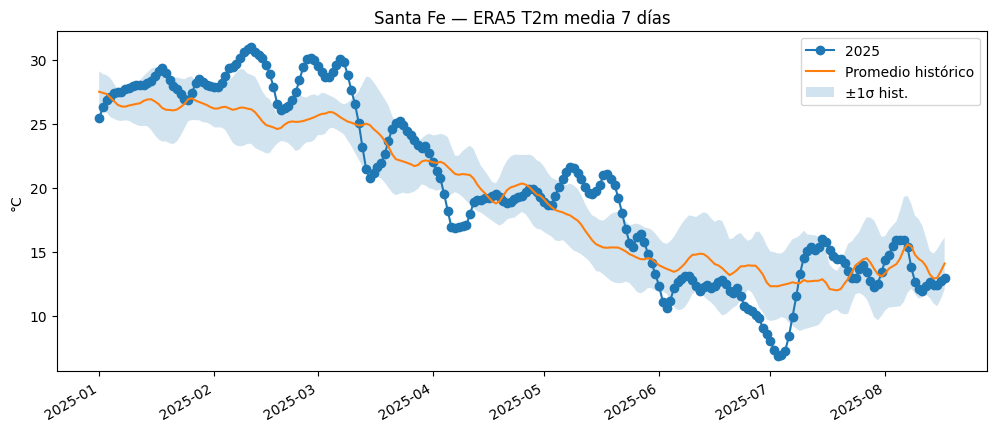

💾 Guardado: plots\lstd7_buenos_aires.png


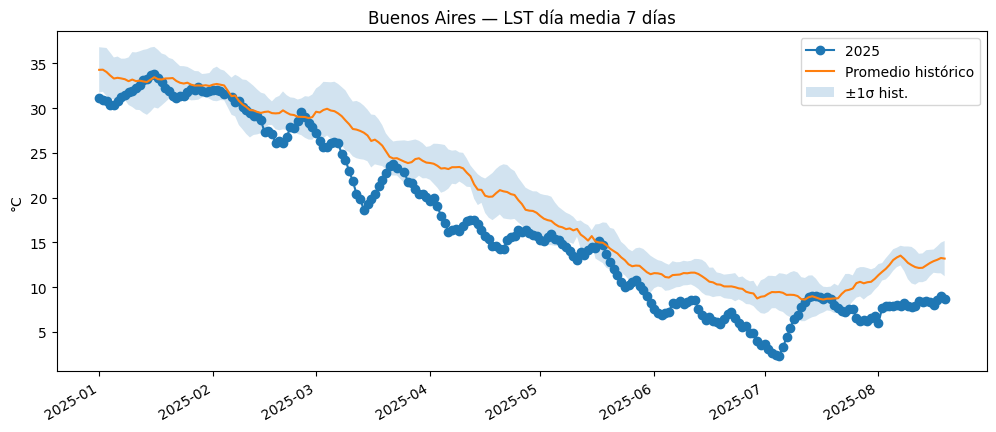

💾 Guardado: plots\lstd7_chaco.png


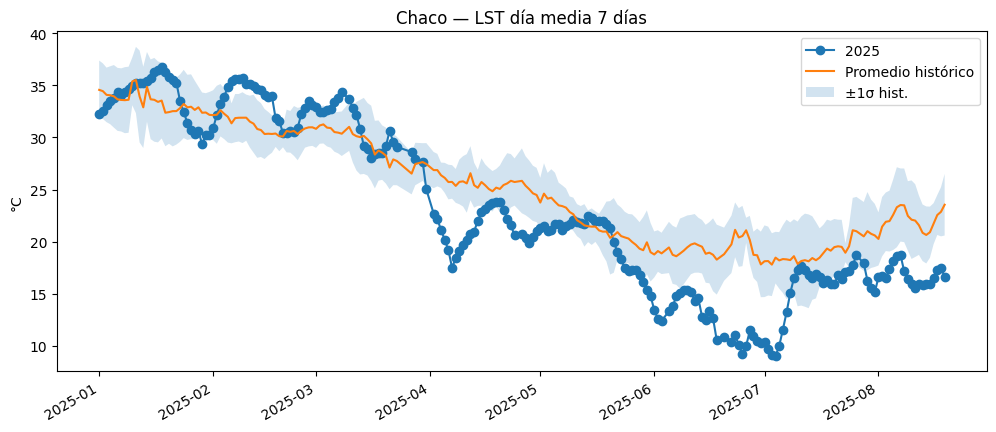

💾 Guardado: plots\lstd7_cordoba.png


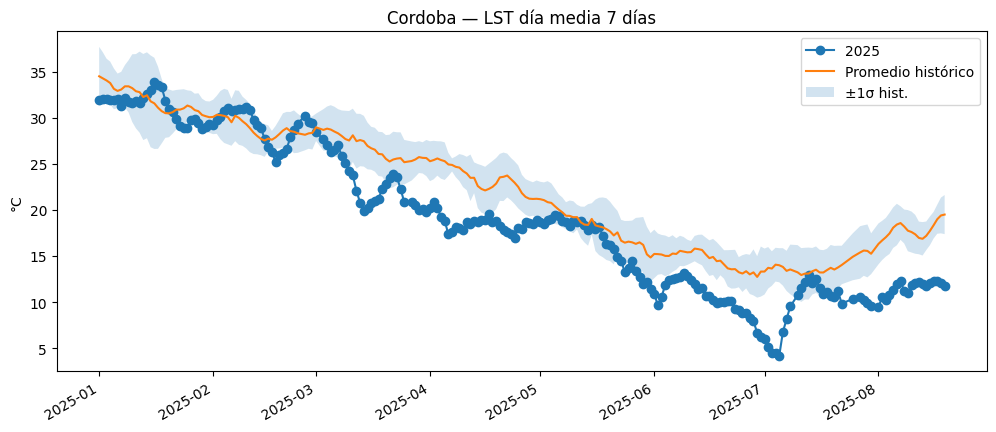

💾 Guardado: plots\lstd7_entre_rios.png


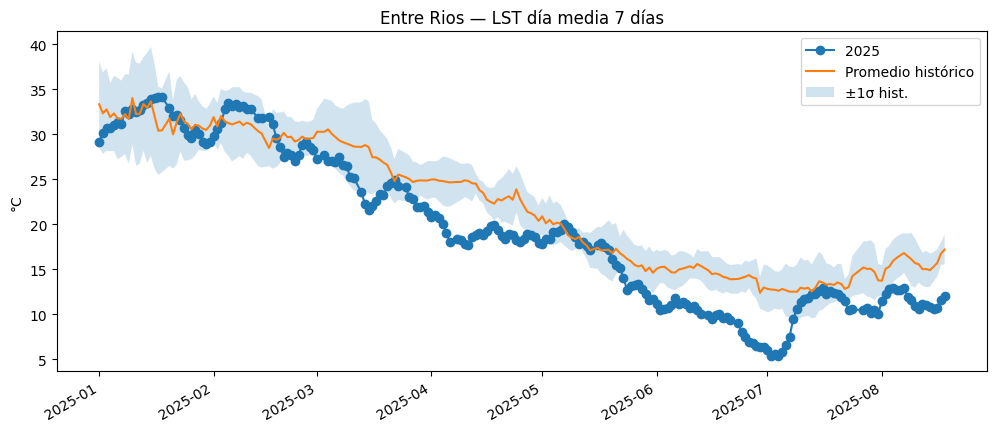

💾 Guardado: plots\lstd7_la_pampa.png


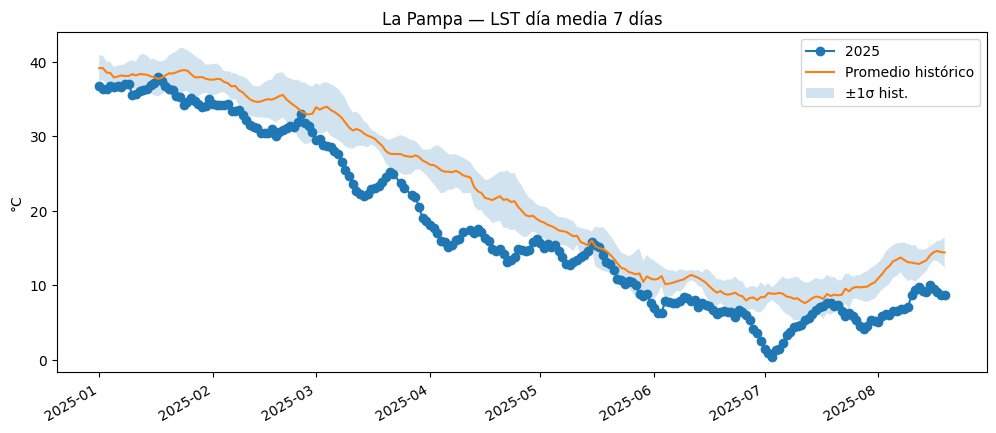

💾 Guardado: plots\lstd7_santa_fe.png


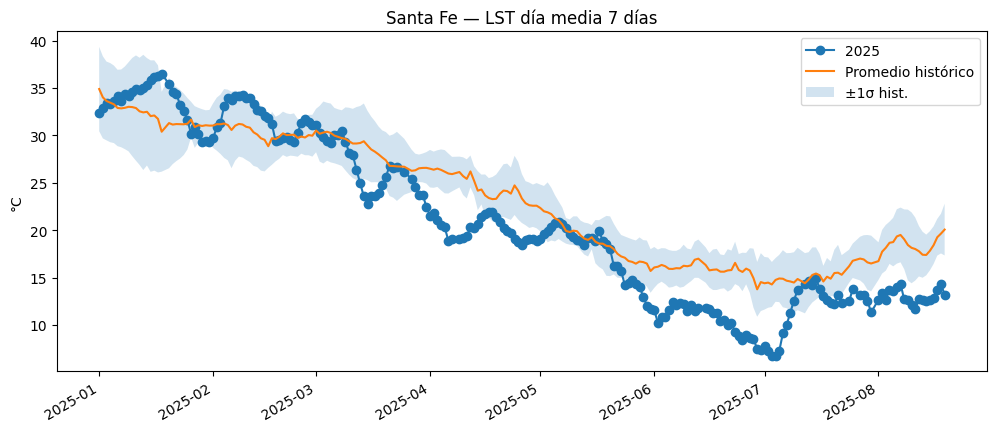

💾 Guardado: plots\lstn7_buenos_aires.png


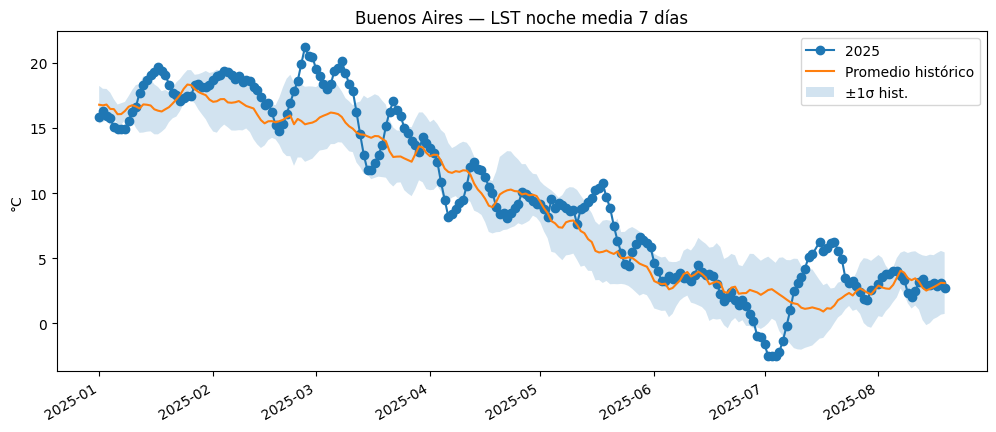

💾 Guardado: plots\lstn7_chaco.png


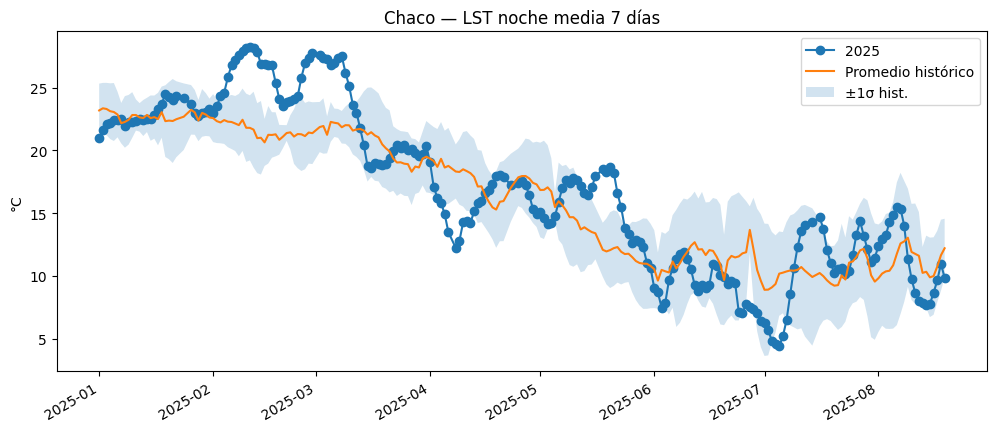

💾 Guardado: plots\lstn7_cordoba.png


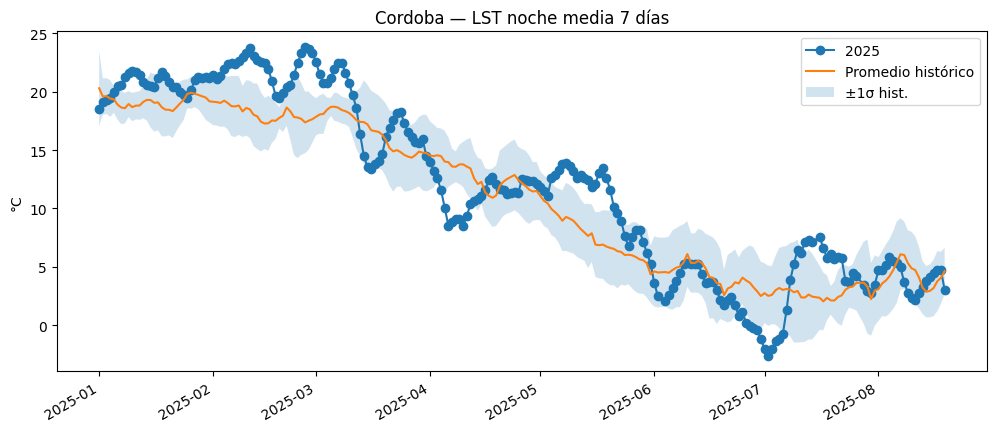

💾 Guardado: plots\lstn7_entre_rios.png


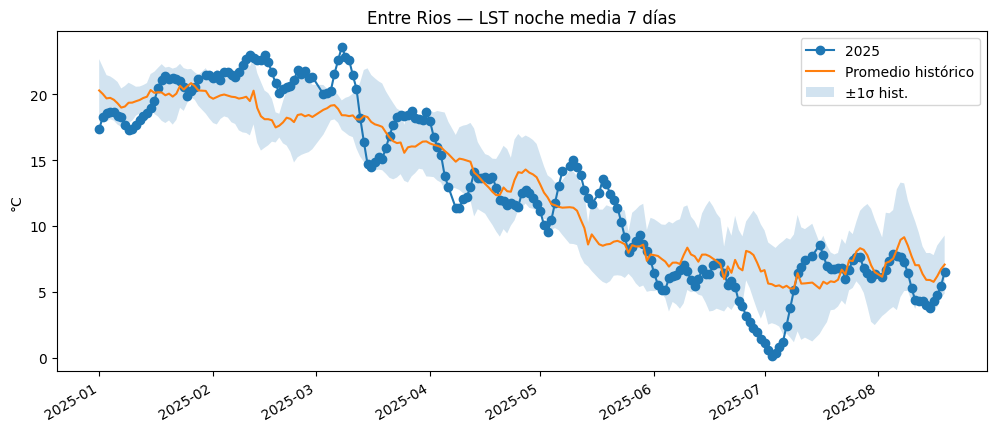

💾 Guardado: plots\lstn7_la_pampa.png


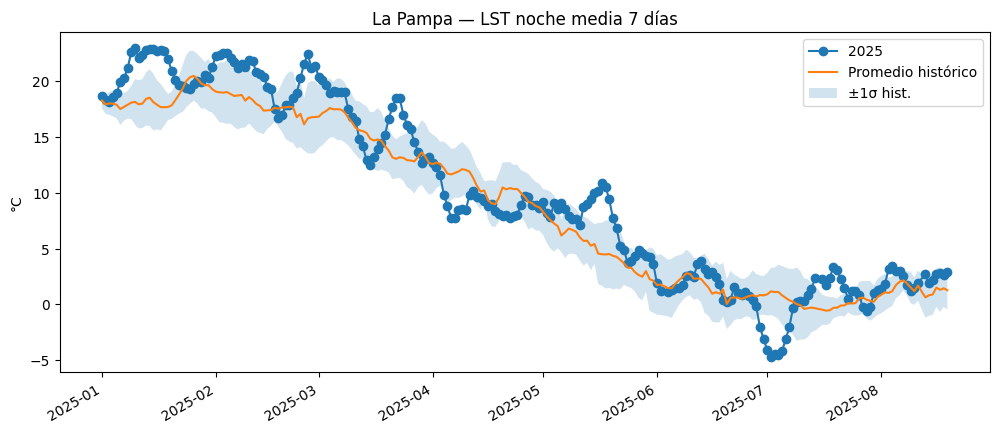

💾 Guardado: plots\lstn7_santa_fe.png


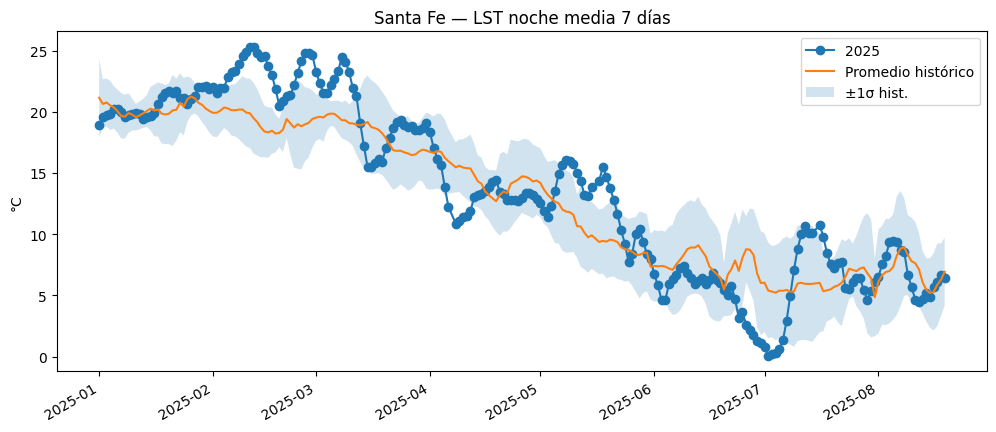

In [ ]:
# ====== Comparación provincia vs promedio histórico (todas las variables) ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Cargar datos (usa df_all_multi si ya lo tenés en memoria; si no, lee CSV)
try:
    df = df_all_multi.copy()
except NameError:
    df = pd.read_csv("gee_alertas_multi_2017_2025.csv", parse_dates=["date"])

# --- Configuración de periodos
HIST_START = "2017-01-01"
HIST_END   = "2024-12-31"
TARGET_YEAR = 2025

# --- Variables a graficar: modo de suavizado y ventana
VARS = [
    {"var":"precip_mm_pref", "label":"Precipitación acumulada 7 días", "unit":"mm", "mode":"sum",  "window":7, "slug":"precip7"},
    {"var":"era5_t2m_C",     "label":"ERA5 T2m media 7 días",          "unit":"°C", "mode":"mean", "window":7, "slug":"t2m7"},
    {"var":"lst_day_C",      "label":"LST día media 7 días",           "unit":"°C", "mode":"mean", "window":7, "slug":"lstd7"},
    {"var":"lst_night_C",    "label":"LST noche media 7 días",         "unit":"°C", "mode":"mean", "window":7, "slug":"lstn7"},
    # Si más adelante activás ET/NDVI, podés sumar:
    # {"var":"modis_et_mm_8d","label":"ET (mm/8d) (mantener sin suavizado)", "unit":"mm/8d","mode":"raw","window":1,"slug":"et8d"},
    # {"var":"modis_ndvi",    "label":"NDVI (sin suavizado)",               "unit":"",     "mode":"raw","window":1,"slug":"ndvi"},
]

# --- Limpieza base
df = df.copy()
df["date"] = pd.to_datetime(df["date"])
for c in ["imerg_precip_mm","era5_precip_mm","precip_mm_pref","era5_t2m_C","lst_day_C","lst_night_C",
          "modis_et_mm_8d","modis_ndvi"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.sort_values(["province","date"])

# --- Helpers
def compute_rolled(df, var, mode="mean", window=7):
    """Devuelve serie suavizada por provincia con 'value', y columnas year/mmdd."""
    d = df[["province","date",var]].dropna().copy()
    d = d.sort_values(["province","date"])
    if mode == "sum":
        d["value"] = d.groupby("province")[var].transform(lambda s: s.rolling(window, min_periods=1).sum())
    elif mode == "mean":
        d["value"] = d.groupby("province")[var].transform(lambda s: s.rolling(window, min_periods=1).mean())
    else:  # raw
        d["value"] = d[var]
    d["year"] = d["date"].dt.year
    d["mmdd"] = d["date"].dt.strftime("%m-%d")
    d = d[d["mmdd"] != "02-29"]
    return d[["province","date","year","mmdd","value"]]

def climatology_from_rolled(d, hist_start=HIST_START, hist_end=HIST_END):
    """Promedio y std por provincia y día-mes, usando la serie ya suavizada."""
    mask = (d["date"] >= pd.to_datetime(hist_start)) & (d["date"] <= pd.to_datetime(hist_end))
    dh = d.loc[mask].copy()
    clim = (dh.groupby(["province","mmdd"])["value"]
              .agg(mean="mean", std="std", count="count")
              .reset_index())
    return clim

def anomalies_vs_clim(d, clim, target_year=TARGET_YEAR):
    """Une el año objetivo con la climatología y calcula anomalías."""
    cur = d[d["year"] == target_year].copy()
    m = cur.merge(clim, on=["province","mmdd"], how="left")
    m["anom"] = m["value"] - m["mean"]
    m["anom_pct"] = np.where(m["mean"].abs() > 1e-9, 100.0 * m["anom"] / m["mean"], np.nan)
    m["zscore"] = (m["anom"] / m["std"]).replace([np.inf, -np.inf], np.nan)
    return m.sort_values(["province","date"])

def plot_var_vs_clim(m, province, title, ylabel, save_dir="plots", filename=None):
    """Grafica 2025 vs promedio histórico con banda ±1σ y guarda PNG."""
    d = m[m["province"] == province].sort_values("date")
    if d.empty:
        print(f"⚠️ Sin datos para {province} en {title}.")
        return
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(d["date"], d["value"], marker="o", label="2025")
    ax.plot(d["date"], d["mean"], label="Promedio histórico")
    if d["std"].notna().any():
        ax.fill_between(d["date"], d["mean"] - d["std"], d["mean"] + d["std"], alpha=0.2, label="±1σ hist.")
    ax.set_title(f"{province} — {title}")
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.autofmt_xdate()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fname = filename or (title.replace(" ", "_").lower() + f"_{province}.png")
        out = os.path.join(save_dir, fname.replace(" ", "_").lower())
        plt.savefig(out, bbox_inches="tight", dpi=140)
        print("💾 Guardado:", out)
    plt.show()

# --- Driver: recorre variables y provincias
provinces = sorted(df["province"].dropna().unique())
for cfg in VARS:
    var = cfg["var"]
    if var not in df.columns:
        print(f"ℹ️ Omito {var}: no está en el DataFrame.")
        continue
    drolled = compute_rolled(df, var, mode=cfg["mode"], window=cfg["window"])
    clim = climatology_from_rolled(drolled, HIST_START, HIST_END)
    m = anomalies_vs_clim(drolled, clim, TARGET_YEAR)
    for prov in provinces:
        plot_var_vs_clim(
            m, prov,
            title=cfg["label"],
            ylabel=cfg["unit"],
            save_dir="plots",
            filename=f"{cfg['slug']}_{prov}.png"
        )


# Codigo optimizado

In [1]:
import ee
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import unicodedata
from functools import reduce as _reduce
from pathlib import Path

# ================= CONFIG =================
PROVINCES = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

# Rangos: histórico para promedio y año actual (END exclusivo)
RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

# Activar datasets
DO_IMERG = True    # precipitación IMERG 30-min -> diario
DO_ERA5  = True    # temp 2m y precip ERA5-Land diario
DO_LST   = True    # MODIS LST día/noche diario
DO_ET    = False   # MODIS ET 8 días (opcional)
DO_NDVI  = False   # MODIS NDVI 16 días (opcional)

# Escalas para promedios espaciales
SCALE_IMERG = 11000
SCALE_ERA5  = 11000
SCALE_LST   = 1000
SCALE_ET    = 500
SCALE_NDVI  = 250

# Salidas (CSV)
CSV_HIST = "gee_alertas_hist_2017_2024.csv"
CSV_CURR = "gee_alertas_2025.csv"
CSV_ALL  = "gee_alertas_multi_2017_2025.csv"

# Modo de actualización
INCREMENTAL_MODE = True   # True: solo nuevos datos; False: volver a descargar todo
BACKFILL_DAYS    = 7      # acolchado para revisiones/retrasos de publicación

# ================= INIT =================
ee.Initialize()

# ================= HELPERS =================
def _norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize('NFD', s)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn').lower().strip()

def provinces_fc(names):
    """FC GAUL(AR) con prop 'province' y geometría; match de nombres sin acentos/mayúsculas."""
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("ADM0_NAME", "Argentina"))
    feats = gaul.getInfo()["features"]
    gaul_map = {_norm(f["properties"]["ADM1_NAME"]): f["properties"]["ADM1_NAME"] for f in feats}
    resolved = []
    for n in names:
        k = _norm(n)
        if k in gaul_map: resolved.append(gaul_map[k])
        else: print(f"⚠️ No encontré '{n}' en GAUL.")
    fc = gaul.filter(ee.Filter.inList("ADM1_NAME", resolved))
    fc = fc.map(lambda f: ee.Feature(ee.Feature(f).geometry(), {"province": ee.Feature(f).get("ADM1_NAME")}))
    try:
        print("✅ Provincias GAUL:", ee.FeatureCollection(fc).aggregate_array('province').getInfo())
    except: pass
    return fc

def dates_list(start_str, end_str):
    start = ee.Date(start_str); end = ee.Date(end_str)
    n = end.difference(start, "day").toInt()
    return ee.List.sequence(0, n.subtract(1)).map(lambda k: start.advance(ee.Number(k), "day"))

def month_range(y0, m0, y1, m1):
    cur = datetime(y0, m0, 1); end = datetime(y1, m1, 1); out = []
    while cur <= end:
        nxty = cur.year + (cur.month // 12); nxtm = (cur.month % 12) + 1
        nxt = datetime(nxty, nxtm, 1)
        out.append((cur.strftime('%Y-%m-%d'), nxt.strftime('%Y-%m-%d')))
        cur = nxt
    return out

def fc_to_df(fc, cols_keep):
    feats = ee.FeatureCollection(fc).getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        rows.append({c: p.get(c) for c in cols_keep})
    return pd.DataFrame(rows, columns=cols_keep) if rows else pd.DataFrame(columns=cols_keep)

def reduce_ic_over_provinces(ic, prov_fc, scale, band_map, dataset_name):
    """
    reduceRegions mean sobre provincias para CADA imagen; devuelve FC sin geometría,
    solo con: province, date, dataset y bandas renombradas.
    """
    in_bands  = list(band_map.keys())
    out_bands = list(band_map.values())
    keys_keep = ee.List(out_bands).cat(ee.List(['province', 'date', 'dataset']))

    def per_image(img):
        img = ee.Image(img).select(in_bands, out_bands)
        dstr = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")
        fc = img.reduceRegions(collection=prov_fc, reducer=ee.Reducer.mean(), scale=scale, tileScale=4) \
                .map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(ee.List(out_bands).cat(ee.List(['province']))))
                     .set({'date': dstr, 'dataset': dataset_name}))
        fc = fc.map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(keys_keep)))
        return fc

    return ee.FeatureCollection(ic.map(per_image).flatten())

# ================= DATASET BUILDERS (CHUNK MENSUAL) =================
PROV_FC = provinces_fc(PROVINCES)

def build_imerg_df_month(ms, me):
    ic_30m = ee.ImageCollection("NASA/GPM_L3/IMERG_V07").filterDate(ms, me).select("precipitation")
    days = dates_list(ms, me)
    def daily_image(d):
        d = ee.Date(d)
        day_ic = ic_30m.filterDate(d, d.advance(1, "day"))
        daily = ee.Image(ee.Algorithms.If(day_ic.size().gt(0), day_ic.sum().multiply(0.5), ee.Image.constant(0))) \
                  .rename("imerg_precip_mm").set("system:time_start", d.millis())
        return daily
    daily_ic = ee.ImageCollection(days.map(daily_image))
    fc = reduce_ic_over_provinces(daily_ic, PROV_FC, SCALE_IMERG, {"imerg_precip_mm":"imerg_precip_mm"}, "IMERG")
    return fc_to_df(fc, ["province","date","imerg_precip_mm"])

def build_era5_df_month(ms, me):
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate(ms, me) \
         .select(["temperature_2m", "total_precipitation_sum"])
    def conv(img):
        t2mC = ee.Image(img).select("temperature_2m").subtract(273.15).rename("era5_t2m_C")
        prmm = ee.Image(img).select("total_precipitation_sum").multiply(1000.0).rename("era5_precip_mm")
        return t2mC.addBands(prmm).copyProperties(img, ["system:time_start"])
    ic = ic.map(conv)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ERA5,
                                  {"era5_t2m_C":"era5_t2m_C","era5_precip_mm":"era5_precip_mm"}, "ERA5")
    return fc_to_df(fc, ["province","date","era5_t2m_C","era5_precip_mm"])

def build_lst_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD11A1").filterDate(ms, me) \
         .select(["LST_Day_1km","LST_Night_1km"])
    def toC(img):
        dayC   = ee.Image(img).select("LST_Day_1km").multiply(0.02).subtract(273.15).rename("lst_day_C")
        nightC = ee.Image(img).select("LST_Night_1km").multiply(0.02).subtract(273.15).rename("lst_night_C")
        return dayC.addBands(nightC).copyProperties(img, ["system:time_start"])
    ic = ic.map(toC)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_LST,
                                  {"lst_day_C":"lst_day_C","lst_night_C":"lst_night_C"}, "MODIS_LST")
    return fc_to_df(fc, ["province","date","lst_day_C","lst_night_C"])

def build_et_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD16A2").filterDate(ms, me).select(["ET"]) \
         .map(lambda img: ee.Image(img).multiply(0.1).rename("modis_et_mm_8d")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ET, {"modis_et_mm_8d":"modis_et_mm_8d"}, "MODIS_ET")
    return fc_to_df(fc, ["province","date","modis_et_mm_8d"])

def build_ndvi_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ms, me).select(["NDVI"]) \
         .map(lambda img: ee.Image(img).multiply(0.0001).rename("modis_ndvi")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_NDVI, {"modis_ndvi":"modis_ndvi"}, "MODIS_NDVI")
    return fc_to_df(fc, ["province","date","modis_ndvi"])

def fetch_range_chunked(start_str, end_str):
    """Descarga rango en chunks mensuales por dataset y hace outer-merge por ['province','date'].""" 
    y0, m0 = int(start_str[:4]), int(start_str[5:7])
    y1, m1 = int(end_str[:4]), int(end_str[5:7])
    months = month_range(y0, m0, y1, m1)

    dfs = []
    if DO_IMERG:
        parts = []
        for ms, me in months:
            print(f"IMERG {ms} → {me}")
            parts.append(build_imerg_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","imerg_precip_mm"]))

    if DO_ERA5:
        parts = []
        for ms, me in months:
            print(f"ERA5 {ms} → {me}")
            parts.append(build_era5_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","era5_t2m_C","era5_precip_mm"]))

    if DO_LST:
        parts = []
        for ms, me in months:
            print(f"LST {ms} → {me}")
            parts.append(build_lst_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))

    if DO_ET:
        parts = []
        for ms, me in months:
            print(f"ET {ms} → {me}")
            parts.append(build_et_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_et_mm_8d"]))

    if DO_NDVI:
        parts = []
        for ms, me in months:
            print(f"NDVI {ms} → {me}")
            parts.append(build_ndvi_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_ndvi"]))

    if not dfs:
        return pd.DataFrame(columns=["province","date"])

    df = _reduce(lambda l, r: pd.merge(l, r, on=["province","date"], how="outer"), dfs)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    # numéricos + precip preferida
    for c in ["imerg_precip_mm","era5_precip_mm","era5_t2m_C","lst_day_C","lst_night_C","modis_et_mm_8d","modis_ndvi"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if {"imerg_precip_mm","era5_precip_mm"}.issubset(df.columns):
        df["precip_mm_pref"] = df["imerg_precip_mm"].fillna(df["era5_precip_mm"])
    elif "era5_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["era5_precip_mm"]
    elif "imerg_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["imerg_precip_mm"]

    return df

# ================= MODO INCREMENTAL =================
def incremental_update(csv_all_path=CSV_ALL, backfill_days=BACKFILL_DAYS):
    today_end = (date.today() + timedelta(days=1)).strftime("%Y-%m-%d")  # end exclusivo

    if Path(csv_all_path).exists() and INCREMENTAL_MODE:
        # 1) Cargar consolidado existente
        df_old = pd.read_csv(csv_all_path)  # sin parse_dates: lo manejamos nosotros
        if df_old.empty:
            last_dt = None
        else:
            s = pd.to_datetime(df_old["date"], errors="coerce")
            last_dt = s.max()
            df_old["date"] = s.dt.strftime("%Y-%m-%d")


        if last_dt is None:
            # Primer fetch si estaba vacío
            print("ℹ️ CSV consolidado vacío. Descargando histórico + 2025…")
            df_hist = fetch_range_chunked(*RANGE_HIST)
            df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
            df_new = pd.concat([df_hist, df_curr], ignore_index=True)
        else:
            # 2) Rango incremental: última fecha - backfill → hoy_end
            inc_start = (last_dt - pd.Timedelta(days=backfill_days)).strftime("%Y-%m-%d")
            print(f"🔄 Modo incremental: {inc_start} → {today_end} (backfill {backfill_days} días)")
            df_new = fetch_range_chunked(inc_start, today_end)

        # 3) Unir y deduplicar (preferimos los registros nuevos)
        df_all_multi = pd.concat([df_old, df_new], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Actualizado:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

    else:
        # Primer corrido o modo full
        if INCREMENTAL_MODE:
            print("📥 Primer corrido (no existe CSV). Descargando histórico + 2025…")
        else:
            print("♻️ FULL REBUILD: re-descargando histórico + 2025…")
        df_hist = fetch_range_chunked(*RANGE_HIST)
        df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
        df_all_multi = pd.concat([df_hist, df_curr], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Guardado inicial:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

# === Ejecutar actualización (incremental o full) ===
df_all_multi = incremental_update()

# ================= CLIMATOLOGÍA + ANOMALÍAS (ejemplo con precip_mm_pref) =================
df = df_all_multi.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["mmdd"] = df["date"].dt.strftime("%m-%d")
var = "precip_mm_pref"

# Climatología 2017–2024
mask_hist = (df["date"] >= pd.to_datetime(RANGE_HIST[0])) & (df["date"] <= pd.to_datetime(RANGE_HIST[1]))
d_hist = df.loc[mask_hist & df[var].notna()].copy()
d_hist = d_hist[d_hist["mmdd"] != "02-29"]
clim = (d_hist.groupby(["province","mmdd"])[var]
          .agg(mean="mean", std="std", count="count")
          .reset_index())

# Anomalías 2025 vs histórico
d_2025 = df[(df["year"] == 2025) & df[var].notna()].copy()
d_2025 = d_2025[d_2025["mmdd"] != "02-29"]
anom = d_2025.merge(clim, on=["province","mmdd"], how="left", suffixes=("", "_clim"))
anom["anom"] = anom[var] - anom["mean"]
anom["anom_pct"] = np.where(anom["mean"].abs() > 1e-9, 100.0 * anom["anom"] / anom["mean"], np.nan)
anom["zscore"] = (anom["anom"] / anom["std"]).replace([np.inf, -np.inf], np.nan)

print("✅ Climatología filas:", len(clim), "| Anomalías 2025 filas:", len(anom))
print(anom[["province","date",var,"mean","anom","anom_pct","zscore"]].head())


✅ Provincias GAUL: ['Buenos Aires', 'Chaco', 'Cordoba', 'Entre Rios', 'La Pampa', 'Santa Fe']
🔄 Modo incremental: 2025-08-24 → 2025-09-01 (backfill 7 días)
IMERG 2025-08-01 → 2025-09-01
IMERG 2025-09-01 → 2025-10-01
ERA5 2025-08-01 → 2025-09-01
ERA5 2025-09-01 → 2025-10-01


C:\Users\Win10\AppData\Local\Temp\ipykernel_12928\2661138801.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","era5_t2m_C","era5_precip_mm"]))


LST 2025-08-01 → 2025-09-01
LST 2025-09-01 → 2025-10-01


C:\Users\Win10\AppData\Local\Temp\ipykernel_12928\2661138801.py:187: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))


✅ Actualizado: gee_alertas_multi_2017_2025.csv | Filas: 19170
✅ Climatología filas: 2190 | Anomalías 2025 filas: 1416
       province       date  precip_mm_pref      mean      anom   anom_pct  \
0  Buenos Aires 2025-01-01        4.934924  5.111599 -0.176675  -3.456350   
1  Buenos Aires 2025-01-02        0.321476  1.862046 -1.540570 -82.735344   
2  Buenos Aires 2025-01-03        0.039218  2.012844 -1.973627 -98.051619   
3  Buenos Aires 2025-01-04        0.020396  0.930555 -0.910159 -97.808205   
4  Buenos Aires 2025-01-05        0.576114  5.876726 -5.300612 -90.196686   

     zscore  
0 -0.027542  
1 -0.405219  
2 -0.468690  
3 -0.629229  
4 -0.655092  


✅ Provincias GAUL: ['Buenos Aires', 'Chaco', 'Cordoba', 'Entre Rios', 'La Pampa', 'Santa Fe']
🔄 Modo incremental: 2025-08-24 → 2025-09-01 (backfill 7 días)
IMERG 2025-08-01 → 2025-09-01
IMERG 2025-09-01 → 2025-10-01
ERA5 2025-08-01 → 2025-09-01
ERA5 2025-09-01 → 2025-10-01


C:\Users\Win10\AppData\Local\Temp\ipykernel_12928\1890019088.py:269: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs.append(pd.concat(parts, ignore_index=True))


LST 2025-08-01 → 2025-09-01
LST 2025-09-01 → 2025-10-01


C:\Users\Win10\AppData\Local\Temp\ipykernel_12928\1890019088.py:276: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))


SMAP 2025-08-01 → 2025-09-01
SMAP 2025-09-01 → 2025-10-01
✅ Actualizado: gee_alertas_multi_2017_2025.csv | Filas: 19170
🗺️ Suelos (textura) ya existe: gee_suelos_textura.csv
💾 Guardado: plots\precip7_buenos_aires.png


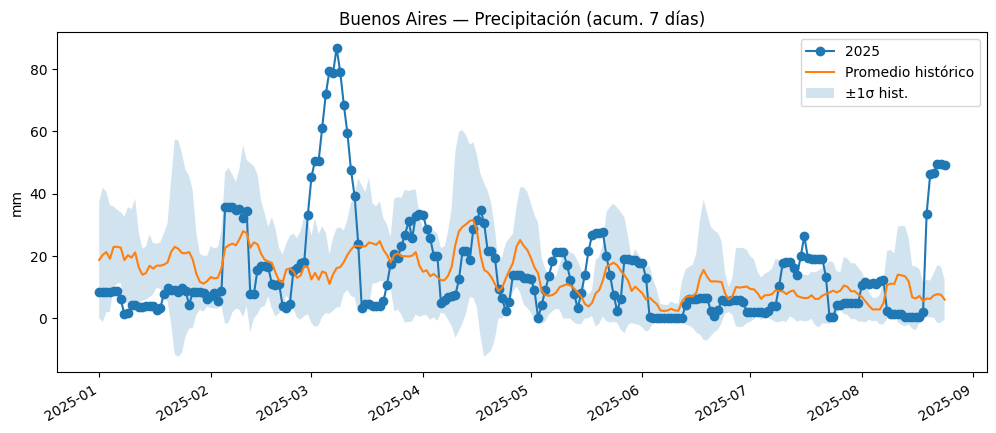

💾 Guardado: plots\precip7_chaco.png


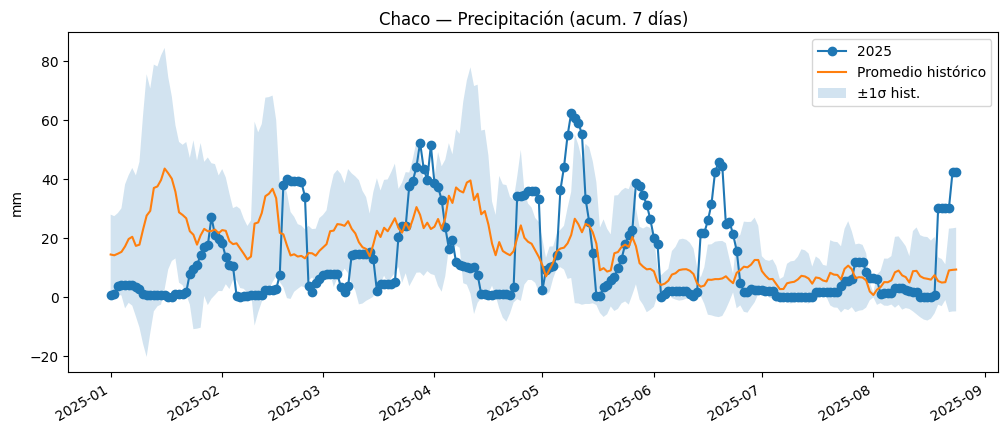

💾 Guardado: plots\precip7_cordoba.png


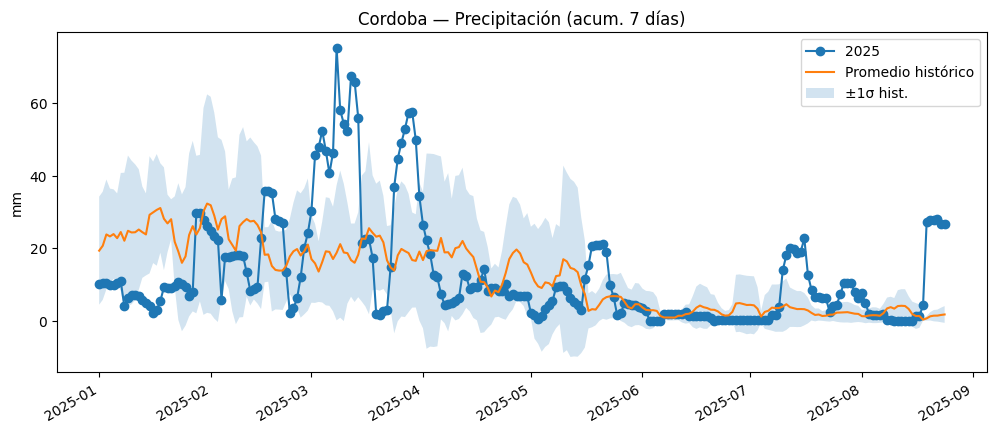

💾 Guardado: plots\precip7_entre_rios.png


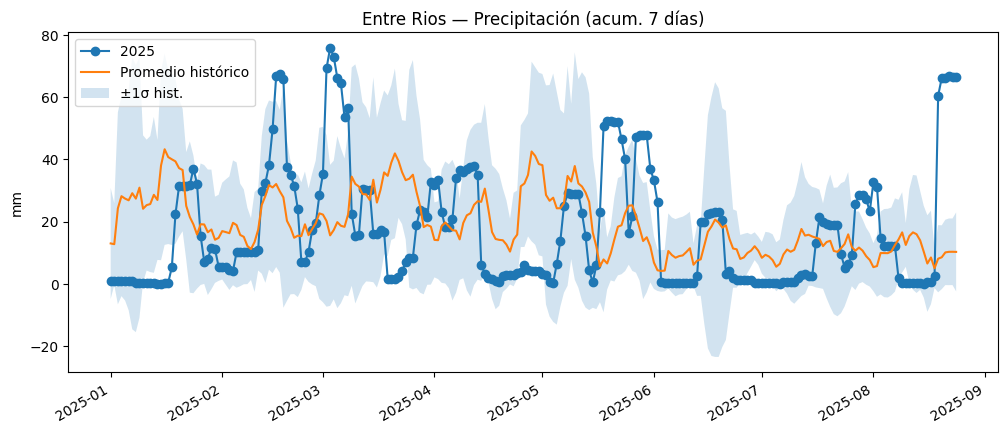

💾 Guardado: plots\precip7_la_pampa.png


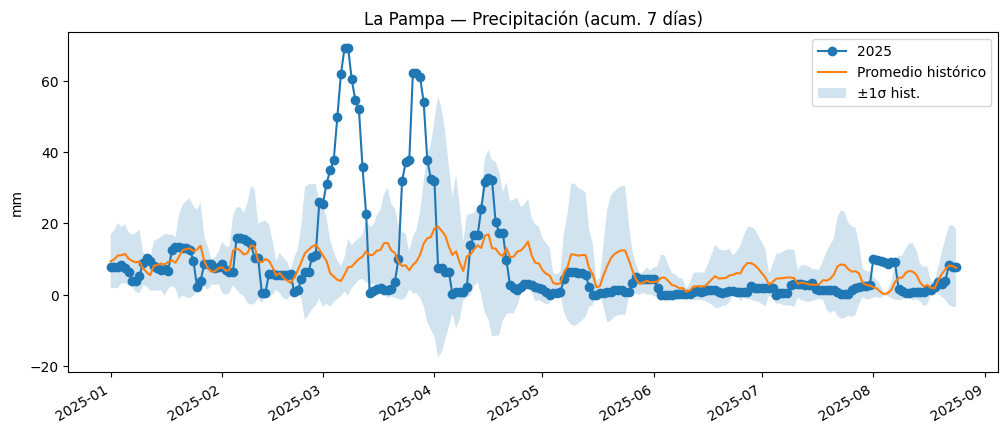

💾 Guardado: plots\precip7_santa_fe.png


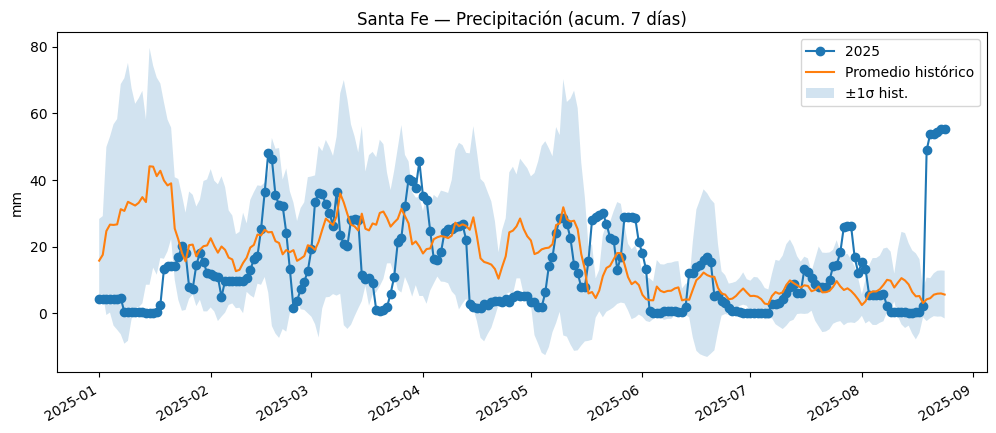

💾 Guardado: plots\t2m7_buenos_aires.png


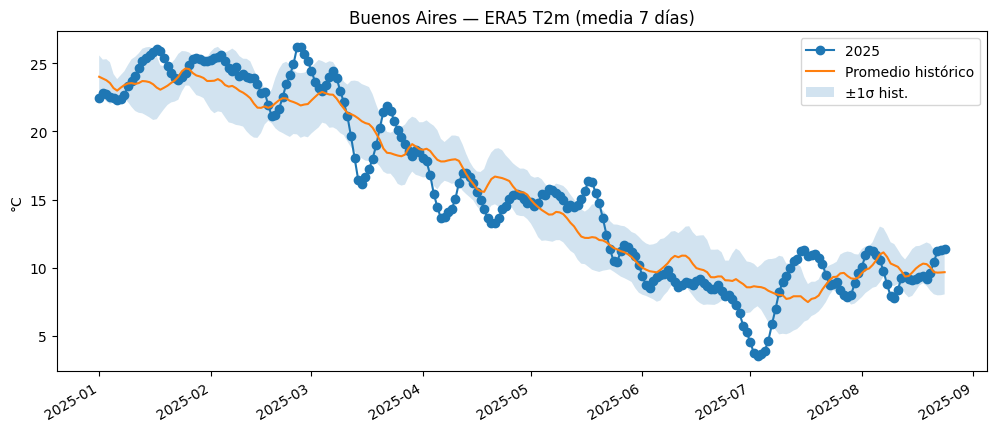

💾 Guardado: plots\t2m7_chaco.png


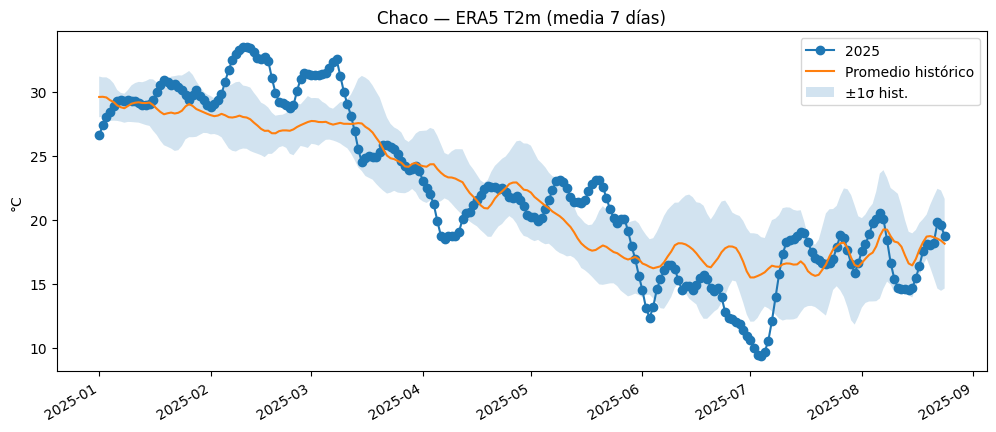

💾 Guardado: plots\t2m7_cordoba.png


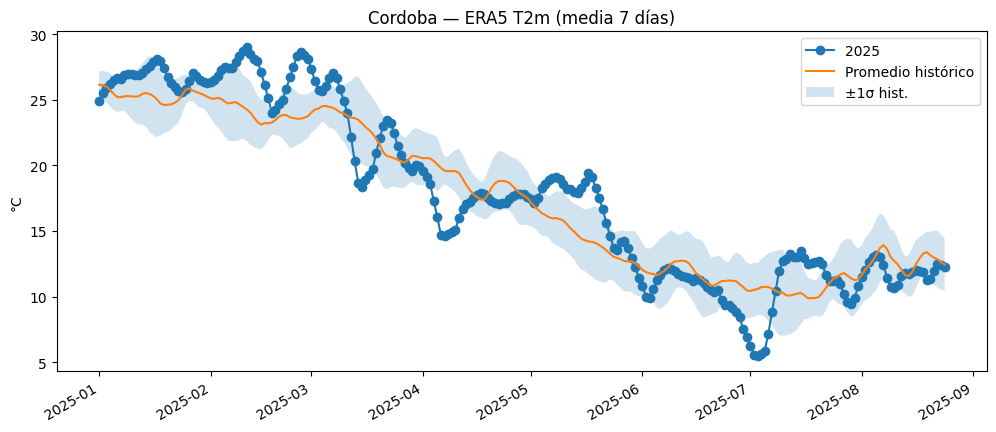

💾 Guardado: plots\t2m7_entre_rios.png


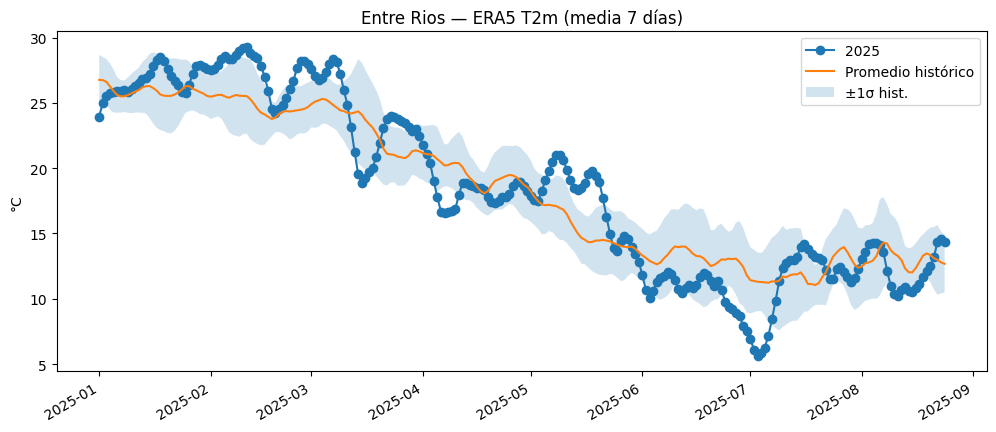

💾 Guardado: plots\t2m7_la_pampa.png


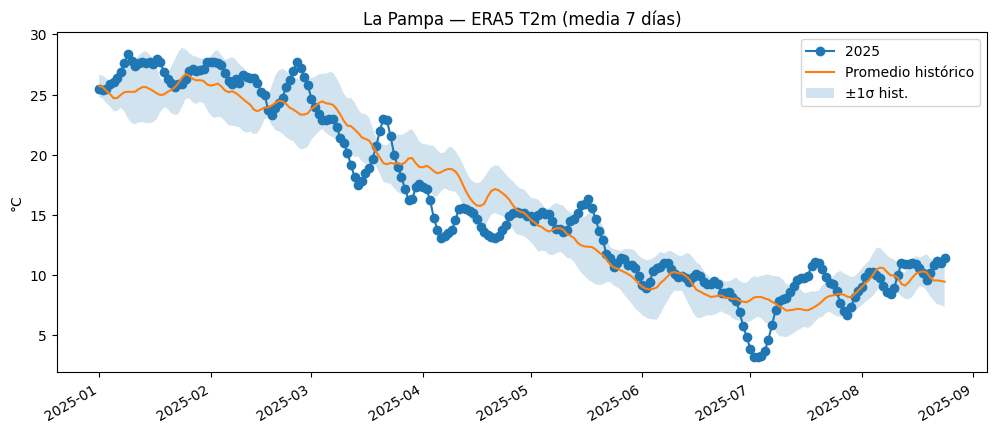

💾 Guardado: plots\t2m7_santa_fe.png


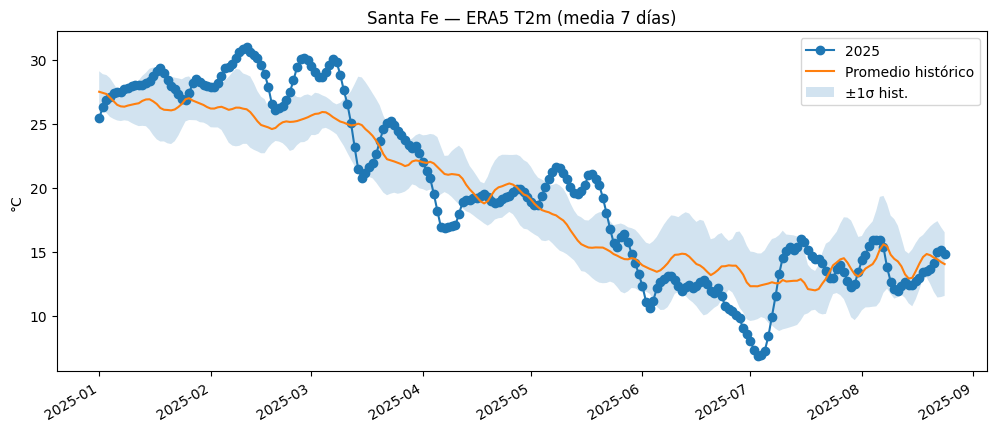

💾 Guardado: plots\lstd7_buenos_aires.png


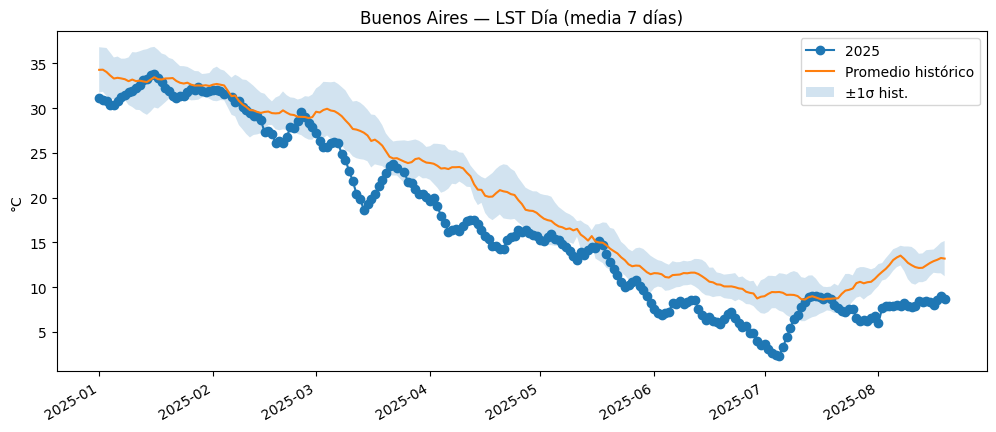

💾 Guardado: plots\lstd7_chaco.png


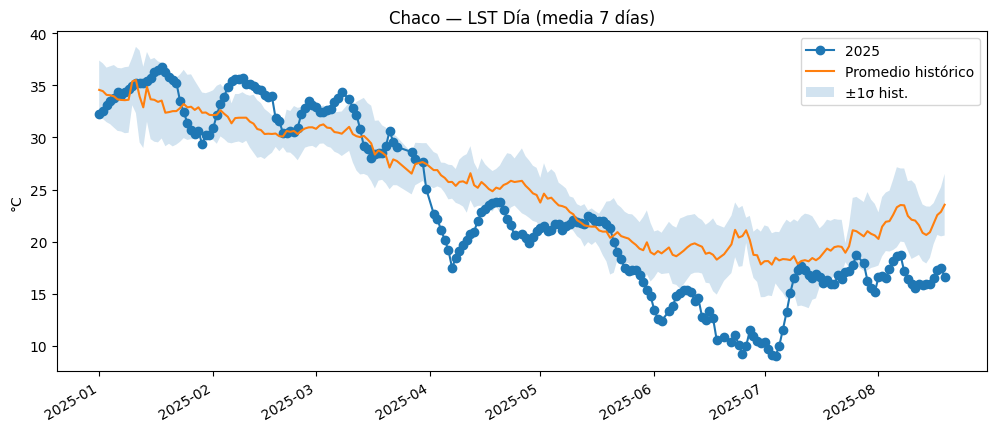

💾 Guardado: plots\lstd7_cordoba.png


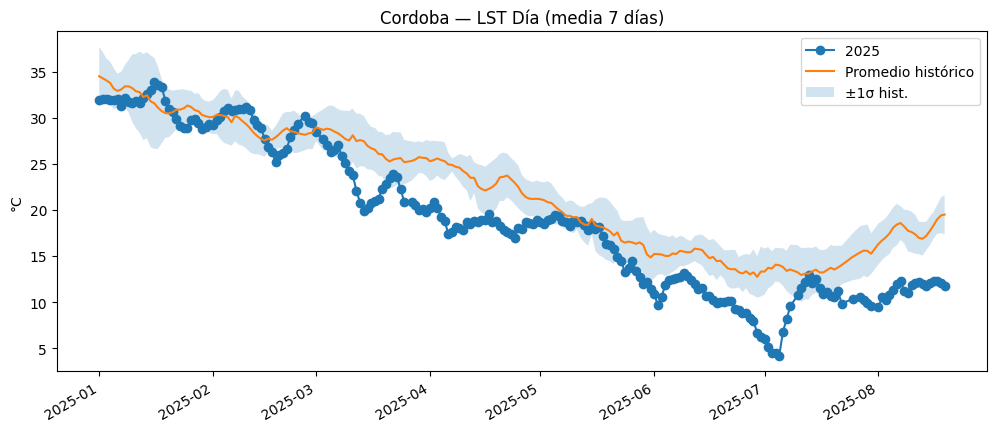

💾 Guardado: plots\lstd7_entre_rios.png


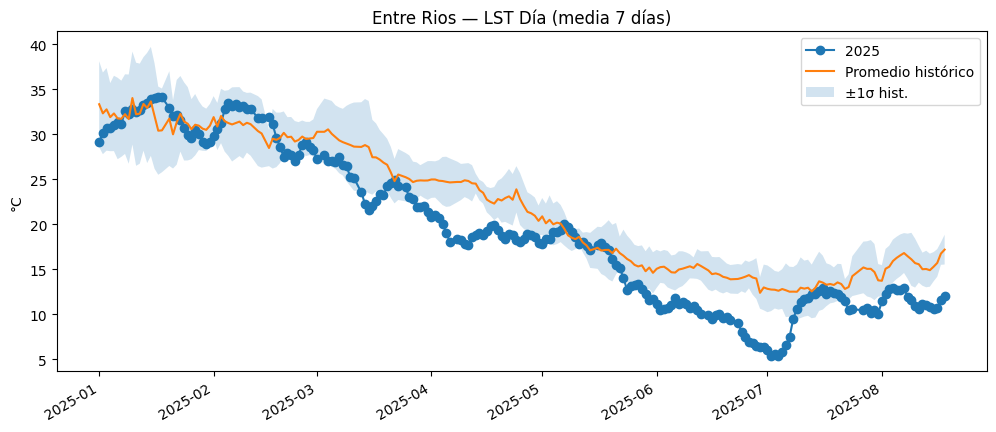

💾 Guardado: plots\lstd7_la_pampa.png


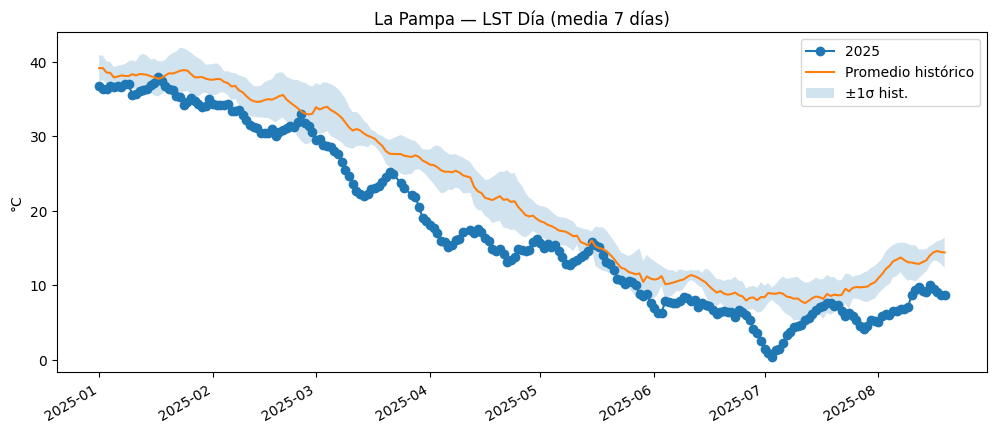

💾 Guardado: plots\lstd7_santa_fe.png


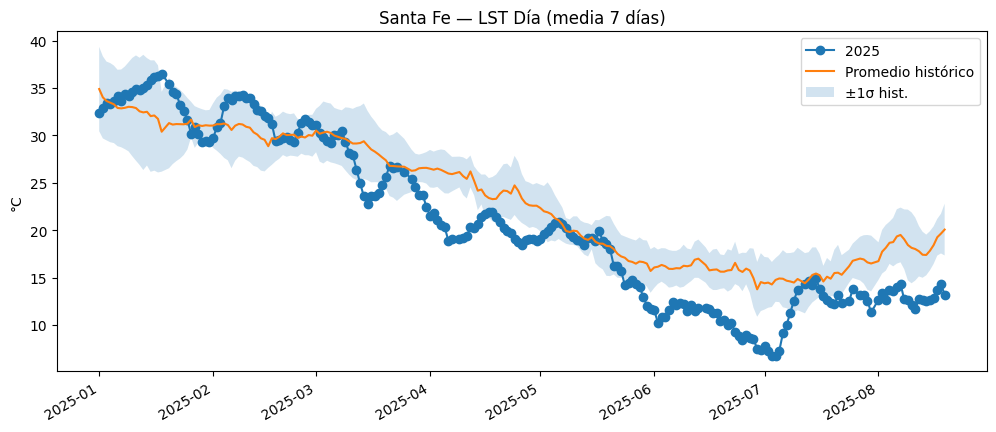

💾 Guardado: plots\lstn7_buenos_aires.png


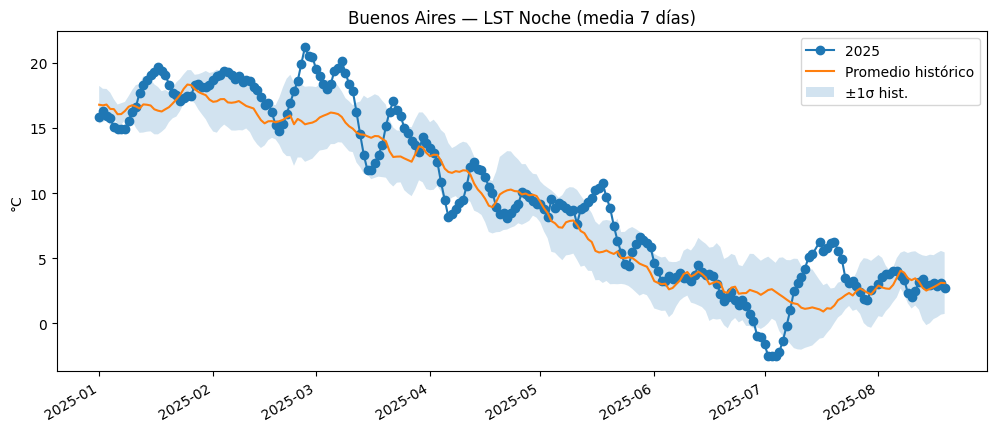

💾 Guardado: plots\lstn7_chaco.png


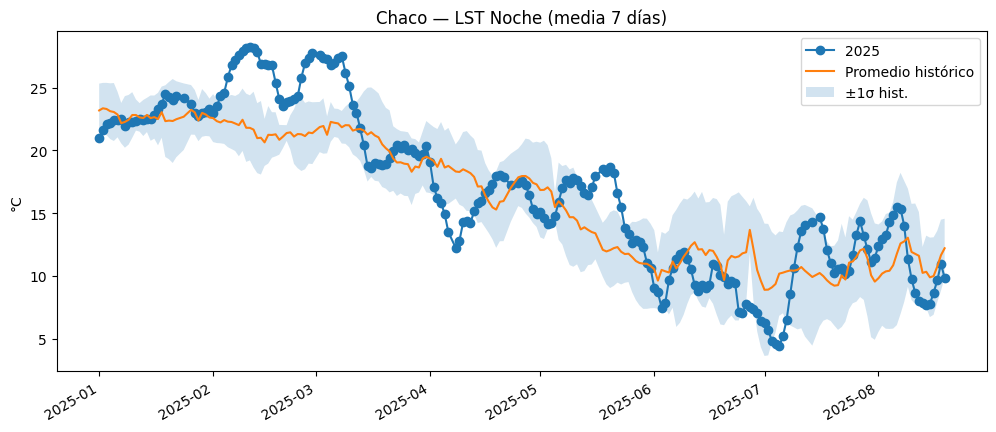

💾 Guardado: plots\lstn7_cordoba.png


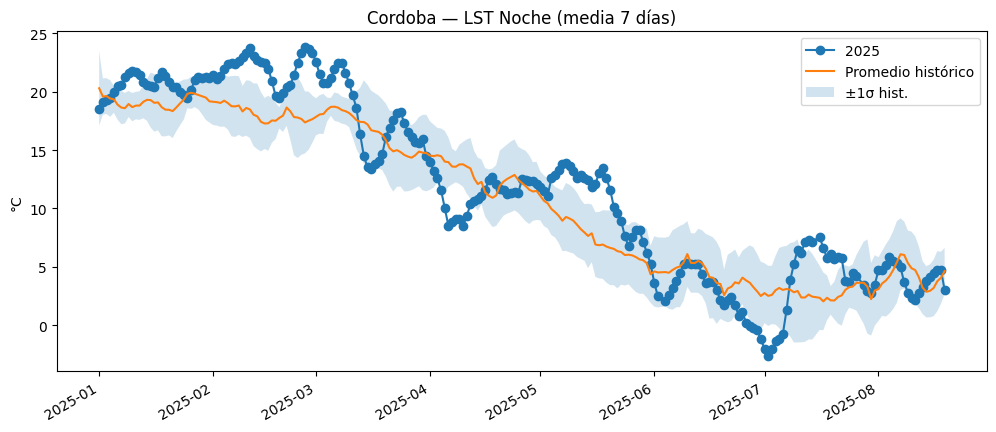

💾 Guardado: plots\lstn7_entre_rios.png


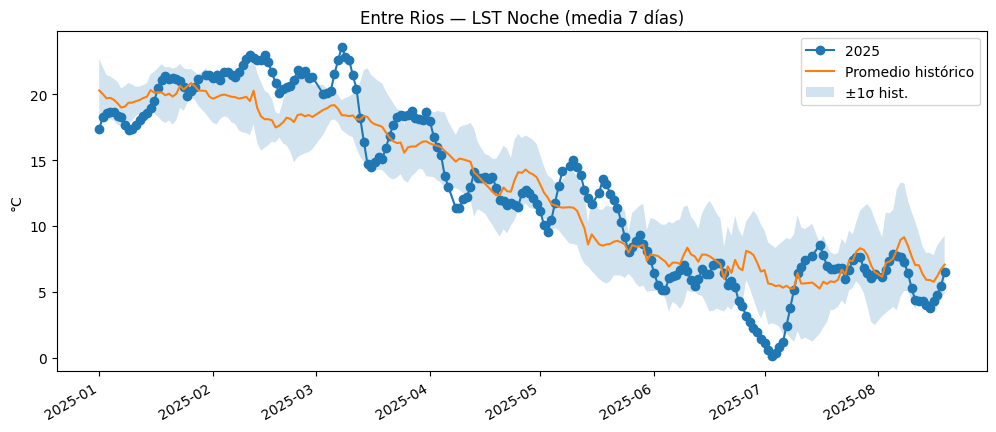

💾 Guardado: plots\lstn7_la_pampa.png


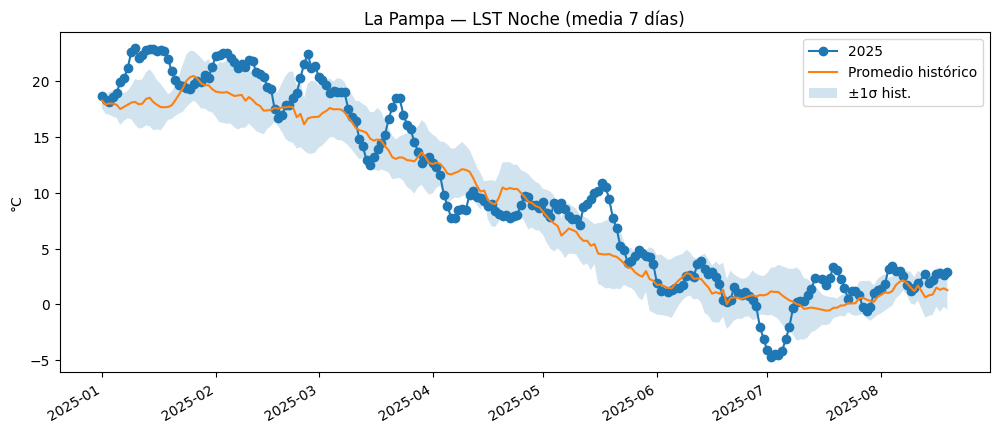

💾 Guardado: plots\lstn7_santa_fe.png


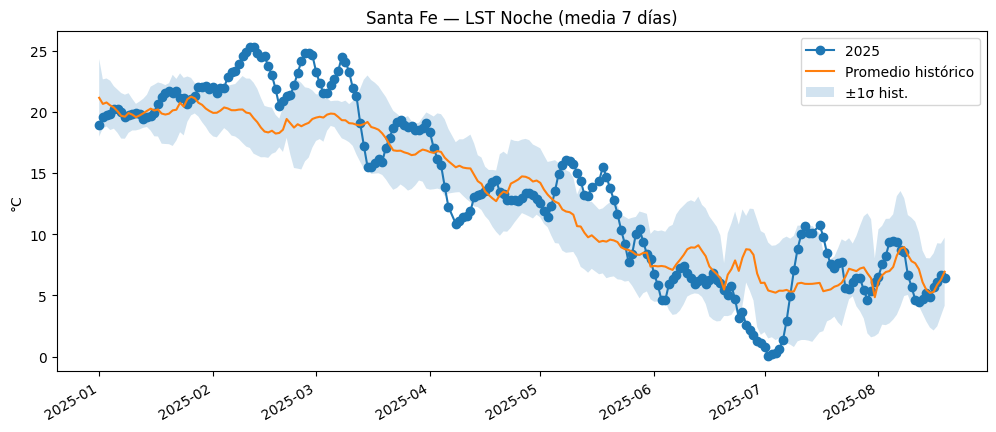

ℹ️ era5_rh_pct: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ era5_vpd_kPa: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ smap_sm: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ era5_swvl1: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ era5_evap_mm: sin histórico 2017–2024 suficiente, se salta la gráfica.
✅ Listo.


In [2]:
# ============================================
# Pipeline GEE + Climatología + Gráficos
# ============================================
import ee
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import unicodedata
from functools import reduce as _reduce
from pathlib import Path
import matplotlib.pyplot as plt
import os

# ================= CONFIG =================
PROVINCES = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

# Rangos: histórico para promedio y año actual (END exclusivo)
RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

# Activar datasets (además de los tradicionales)
DO_IMERG    = True   # precipitación IMERG 30-min -> diario
DO_ERA5     = True   # temp 2m y precip ERA5-Land diario
DO_LST      = True   # MODIS LST día/noche diario
DO_ET       = False  # MODIS ET 8 días (opcional)
DO_NDVI     = False  # MODIS NDVI 16 días (opcional)

# NUEVOS
DO_RH       = True   # humedad relativa (ERA5) y VPD
DO_SM_ERA5  = True   # humedad de suelo ERA5 swvl1 (0–7 cm)
DO_ERA5_ET  = True   # evaporación diaria ERA5 (mm/día)
DO_SMAP     = True   # humedad de suelo satelital SMAP (0–5 cm aprox.)
DO_SOIL_TEXTURE = True  # textura de suelos (estático, OpenLandMap)

# Escalas para promedios espaciales (m)
SCALE_IMERG = 11000
SCALE_ERA5  = 11000
SCALE_LST   = 1000
SCALE_ET    = 500
SCALE_NDVI  = 250
SCALE_SMAP  = 9000   # ~9 km

# Salidas (CSV)
CSV_HIST = "gee_alertas_hist_2017_2024.csv"
CSV_CURR = "gee_alertas_2025.csv"
CSV_ALL  = "gee_alertas_multi_2017_2025.csv"
CSV_SOIL_TEXTURE = "gee_suelos_textura.csv"

# Modo de actualización
INCREMENTAL_MODE = True     # True: solo nuevos datos; False: bajar todo de nuevo
BACKFILL_DAYS    = 7        # acolchado para revisiones/retrasos
DO_BACKFILL_FOR_NEW_VARS = False  # poner True si querés promedios históricos de las variables NUEVAS (tarda bastante)

# ================= INIT =================
ee.Initialize()

# ================= HELPERS =================
def _parse_date_mixed(s):
    """Parsea fechas mixtas (con/sin hora) a datetime64[ns]. Soporta pandas 1.x/2.x."""
    try:
        return pd.to_datetime(s, errors="coerce", format="mixed")
    except TypeError:
        return pd.to_datetime(s, errors="coerce", infer_datetime_format=True)

def _normalize_date_col(df):
    """Fuerza 'date' como string ISO YYYY-MM-DD (sin hora)."""
    df = df.copy()
    dts = _parse_date_mixed(df["date"])
    df["date"] = dts.dt.strftime("%Y-%m-%d")
    return df

def _norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize('NFD', s)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn').lower().strip()

def provinces_fc(names):
    """FC GAUL(AR) con 'province' y geometría; match insensible a acentos."""
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("ADM0_NAME", "Argentina"))
    feats = gaul.getInfo()["features"]
    gaul_map = {_norm(f["properties"]["ADM1_NAME"]): f["properties"]["ADM1_NAME"] for f in feats}
    resolved = []
    for n in names:
        k = _norm(n)
        if k in gaul_map: resolved.append(gaul_map[k])
        else: print(f"⚠️ No encontré '{n}' en GAUL.")
    fc = gaul.filter(ee.Filter.inList("ADM1_NAME", resolved))
    fc = fc.map(lambda f: ee.Feature(ee.Feature(f).geometry(), {"province": ee.Feature(f).get("ADM1_NAME")}))
    try:
        print("✅ Provincias GAUL:", ee.FeatureCollection(fc).aggregate_array('province').getInfo())
    except: pass
    return fc

def dates_list(start_str, end_str):
    start = ee.Date(start_str); end = ee.Date(end_str)
    n = end.difference(start, "day").toInt()
    return ee.List.sequence(0, n.subtract(1)).map(lambda k: start.advance(ee.Number(k), "day"))

def month_range(y0, m0, y1, m1):
    cur = datetime(y0, m0, 1); end = datetime(y1, m1, 1); out = []
    while cur <= end:
        nxty = cur.year + (cur.month // 12); nxtm = (cur.month % 12) + 1
        nxt = datetime(nxty, nxtm, 1)
        out.append((cur.strftime('%Y-%m-%d'), nxt.strftime('%Y-%m-%d')))
        cur = nxt
    return out

def fc_to_df(fc, cols_keep):
    feats = ee.FeatureCollection(fc).getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        rows.append({c: p.get(c) for c in cols_keep})
    return pd.DataFrame(rows, columns=cols_keep) if rows else pd.DataFrame(columns=cols_keep)

def reduce_ic_over_provinces(ic, prov_fc, scale, band_map, dataset_name):
    """reduceRegions mean sobre provincias por imagen; devuelve FC sin geometría."""
    in_bands  = list(band_map.keys())
    out_bands = list(band_map.values())
    keys_keep = ee.List(out_bands).cat(ee.List(['province', 'date', 'dataset']))
    def per_image(img):
        img = ee.Image(img).select(in_bands, out_bands)
        dstr = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")
        fc = img.reduceRegions(collection=prov_fc, reducer=ee.Reducer.mean(), scale=scale, tileScale=4) \
                .map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(ee.List(out_bands).cat(ee.List(['province']))))
                     .set({'date': dstr, 'dataset': dataset_name}))
        fc = fc.map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(keys_keep)))
        return fc
    return ee.FeatureCollection(ic.map(per_image).flatten())

# ================= DATASET BUILDERS (CHUNK MENSUAL) =================
PROV_FC = provinces_fc(PROVINCES)

# IMERG -> precip diaria (mm)
def build_imerg_df_month(ms, me):
    ic_30m = ee.ImageCollection("NASA/GPM_L3/IMERG_V07").filterDate(ms, me).select("precipitation")
    days = dates_list(ms, me)
    def daily_image(d):
        d = ee.Date(d)
        day_ic = ic_30m.filterDate(d, d.advance(1, "day"))
        daily = ee.Image(ee.Algorithms.If(day_ic.size().gt(0), day_ic.sum().multiply(0.5), ee.Image.constant(0))) \
                  .rename("imerg_precip_mm").set("system:time_start", d.millis())
        return daily
    daily_ic = ee.ImageCollection(days.map(daily_image))
    fc = reduce_ic_over_provinces(daily_ic, PROV_FC, SCALE_IMERG, {"imerg_precip_mm":"imerg_precip_mm"}, "IMERG")
    return fc_to_df(fc, ["province","date","imerg_precip_mm"])

# ERA5 -> T2m (°C), precip (mm), RH (%), VPD (kPa), SWVL1, ET diaria (mm)
def build_era5_df_month(ms, me):
    bands = ["temperature_2m", "dewpoint_temperature_2m", "total_precipitation_sum"]
    if DO_SM_ERA5:
        bands.append("volumetric_soil_water_layer_1")   # 0–7 cm (m3/m3)
    if DO_ERA5_ET:
        bands.append("total_evaporation_sum")           # m
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate(ms, me).select(bands)
    def conv(img):
        img = ee.Image(img)
        tC  = img.select("temperature_2m").subtract(273.15)
        tdC = img.select("dewpoint_temperature_2m").subtract(273.15)
        es = tC.multiply(17.67).divide(tC.add(243.5)).exp().multiply(6.112)
        e  = tdC.multiply(17.67).divide(tdC.add(243.5)).exp().multiply(6.112)
        rh = e.divide(es).multiply(100).clamp(0, 100).rename("era5_rh_pct")
        vpd = es.subtract(e).divide(10.0).rename("era5_vpd_kPa")  # hPa → kPa
        t2mC = tC.rename("era5_t2m_C")
        prmm = img.select("total_precipitation_sum").multiply(1000.0).rename("era5_precip_mm")
        out = t2mC.addBands([prmm, rh, vpd])
        if DO_SM_ERA5:
            out = out.addBands(img.select("volumetric_soil_water_layer_1").rename("era5_swvl1"))
        if DO_ERA5_ET:
            out = out.addBands(img.select("total_evaporation_sum").multiply(1000.0).rename("era5_evap_mm"))
        return out.copyProperties(img, ["system:time_start"])
    ic_conv = ic.map(conv)
    keep_all = ["era5_t2m_C","era5_precip_mm","era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm"]
    try:
        bn = set(ee.Image(ic_conv.first()).bandNames().getInfo())
        keep = [k for k in keep_all if k in bn]
    except Exception:
        keep = keep_all
    fc = reduce_ic_over_provinces(ic_conv, PROV_FC, SCALE_ERA5, {k: k for k in keep}, "ERA5")
    return fc_to_df(fc, ["province","date"] + keep)

# MODIS LST diario -> °C
def build_lst_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD11A1").filterDate(ms, me).select(["LST_Day_1km","LST_Night_1km"])
    def toC(img):
        dayC   = ee.Image(img).select("LST_Day_1km").multiply(0.02).subtract(273.15).rename("lst_day_C")
        nightC = ee.Image(img).select("LST_Night_1km").multiply(0.02).subtract(273.15).rename("lst_night_C")
        return dayC.addBands(nightC).copyProperties(img, ["system:time_start"])
    ic = ic.map(toC)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_LST,
                                  {"lst_day_C":"lst_day_C","lst_night_C":"lst_night_C"}, "MODIS_LST")
    return fc_to_df(fc, ["province","date","lst_day_C","lst_night_C"])

# MODIS ET 8-días (opcional)
def build_et_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD16A2").filterDate(ms, me).select(["ET"]) \
         .map(lambda img: ee.Image(img).multiply(0.1).rename("modis_et_mm_8d")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ET, {"modis_et_mm_8d":"modis_et_mm_8d"}, "MODIS_ET")
    return fc_to_df(fc, ["province","date","modis_et_mm_8d"])

# MODIS NDVI 16-días (opcional)
def build_ndvi_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ms, me).select(["NDVI"]) \
         .map(lambda img: ee.Image(img).multiply(0.0001).rename("modis_ndvi")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_NDVI, {"modis_ndvi":"modis_ndvi"}, "MODIS_NDVI")
    return fc_to_df(fc, ["province","date","modis_ndvi"])

# SMAP soil moisture (am/pm con QC)
def build_smap_df_month(ms, me):
    ic = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
            .filterDate(ms, me)
            .select(["soil_moisture_am","soil_moisture_pm",
                     "retrieval_qual_flag_am","retrieval_qual_flag_pm"]))
    def combine(img):
        img = ee.Image(img)
        am  = img.select("soil_moisture_am")
        pm  = img.select("soil_moisture_pm")
        qam = img.select("retrieval_qual_flag_am").eq(0)
        qpm = img.select("retrieval_qual_flag_pm").eq(0)
        am  = am.updateMask(qam)
        pm  = pm.updateMask(qpm)
        count = am.mask().gt(0).rename("c1").add(pm.mask().gt(0).rename("c2"))
        sm = am.add(pm).divide(count.max(1)).rename("smap_sm")
        return sm.copyProperties(img, ["system:time_start"])
    ic2 = ic.map(combine)
    fc = reduce_ic_over_provinces(ic2, PROV_FC, SCALE_SMAP, {"smap_sm":"smap_sm"}, "SMAP")
    return fc_to_df(fc, ["province","date","smap_sm"])

# Textura de suelos (estático)
SOIL_TEXTURE_MAP = {1:"Cl",2:"SiCl",3:"SaCl",4:"ClLo",5:"SiClLo",6:"SaClLo",
                    7:"Lo",8:"SiLo",9:"SaLo",10:"Si",11:"LoSa",12:"Sa"}

def build_soil_texture_static():
    img = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02").select("b0")
    mode_fc = img.reduceRegions(PROV_FC, ee.Reducer.mode(), scale=250, tileScale=4)
    feats = mode_fc.getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        val = int(p.get("mode")) if p.get("mode") is not None else None
        rows.append({
            "province": p.get("province"),
            "soil_texture_mode_code": val,
            "soil_texture_mode": SOIL_TEXTURE_MAP.get(val, None)
        })
    return pd.DataFrame(rows).sort_values("province")

# === Descarga chunk mensual y merge por ['province','date']
def fetch_range_chunked(start_str, end_str):
    y0, m0 = int(start_str[:4]), int(start_str[5:7])
    y1, m1 = int(end_str[:4]), int(end_str[5:7])
    months = month_range(y0, m0, y1, m1)

    dfs = []
    if DO_IMERG:
        parts = []
        for ms, me in months:
            print(f"IMERG {ms} → {me}")
            parts.append(build_imerg_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","imerg_precip_mm"]))

    if DO_ERA5 or DO_RH or DO_SM_ERA5 or DO_ERA5_ET:
        parts = []
        for ms, me in months:
            print(f"ERA5 {ms} → {me}")
            parts.append(build_era5_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True))

    if DO_LST:
        parts = []
        for ms, me in months:
            print(f"LST {ms} → {me}")
            parts.append(build_lst_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))

    if DO_ET:
        parts = []
        for ms, me in months:
            print(f"ET {ms} → {me}")
            parts.append(build_et_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_et_mm_8d"]))

    if DO_NDVI:
        parts = []
        for ms, me in months:
            print(f"NDVI {ms} → {me}")
            parts.append(build_ndvi_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_ndvi"]))

    if DO_SMAP:
        parts = []
        for ms, me in months:
            print(f"SMAP {ms} → {me}")
            parts.append(build_smap_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","smap_sm"]))

    if not dfs:
        return pd.DataFrame(columns=["province","date"])

    df = _reduce(lambda l, r: pd.merge(l, r, on=["province","date"], how="outer"), dfs)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    # numéricos + precip preferida
    for c in ["imerg_precip_mm","era5_precip_mm","era5_t2m_C","lst_day_C","lst_night_C",
              "modis_et_mm_8d","modis_ndvi","era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm","smap_sm"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

    if {"imerg_precip_mm","era5_precip_mm"}.issubset(df.columns):
        df["precip_mm_pref"] = df["imerg_precip_mm"].fillna(df["era5_precip_mm"])
    elif "era5_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["era5_precip_mm"]
    elif "imerg_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["imerg_precip_mm"]

    return df

# ================= MODO INCREMENTAL =================
def incremental_update(csv_all_path=CSV_ALL, backfill_days=BACKFILL_DAYS):
    today_end = (date.today() + timedelta(days=1)).strftime("%Y-%m-%d")  # end exclusivo
    today_end_dt = pd.to_datetime(today_end)

    if Path(csv_all_path).exists() and INCREMENTAL_MODE:
        # 1) Cargar consolidado existente (como strings), normalizar y parsear seguro
        df_old = pd.read_csv(csv_all_path)
        if "date" not in df_old.columns or df_old.empty:
            last_dt = None
        else:
            df_old = _normalize_date_col(df_old)
            last_dt = pd.to_datetime(df_old["date"], errors="coerce").max()

        if (last_dt is None) or pd.isna(last_dt):
            print("ℹ️ CSV consolidado vacío. Descargando histórico + 2025…")
            df_hist = fetch_range_chunked(*RANGE_HIST)
            df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
            df_new = pd.concat([df_hist, df_curr], ignore_index=True)
        else:
            # Clamp por si last_dt quedó en el futuro
            if last_dt >= today_end_dt:
                last_dt = today_end_dt - pd.Timedelta(days=1)
            # 2) Rango incremental: (last_dt - backfill) → today_end
            inc_start_dt = max(pd.to_datetime(RANGE_CURR[0]), last_dt - pd.Timedelta(days=backfill_days))
            if inc_start_dt >= today_end_dt:
                inc_start_dt = today_end_dt - pd.Timedelta(days=backfill_days+1)
            inc_start = inc_start_dt.strftime("%Y-%m-%d")
            print(f"🔄 Modo incremental: {inc_start} → {today_end} (backfill {backfill_days} días)")
            df_new = fetch_range_chunked(inc_start, today_end)

        # 3) Unir y deduplicar
        df_all_multi = pd.concat([df_old, df_new], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi = _normalize_date_col(df_all_multi)
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Actualizado:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

    else:
        # Primer corrido o full rebuild
        if INCREMENTAL_MODE:
            print("📥 Primer corrido (no existe CSV). Descargando histórico + 2025…")
        else:
            print("♻️ FULL REBUILD: re-descargando histórico + 2025…")
        df_hist = fetch_range_chunked(*RANGE_HIST)
        df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
        df_all_multi = pd.concat([df_hist, df_curr], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi = _normalize_date_col(df_all_multi)
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Guardado inicial:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

# === Ejecutar actualización (incremental o full) ===
df_all_multi = incremental_update()

# === Backfill histórico para variables NUEVAS (opcional) ===
NEW_VARS = ["era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm","smap_sm"]

def needs_backfill(df, vars_list, hist_range):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    mask_hist = (d["date"] >= pd.to_datetime(hist_range[0])) & (d["date"] <= pd.to_datetime(hist_range[1]))
    d = d.loc[mask_hist]
    to_fetch = []
    for v in vars_list:
        if v not in d.columns:
            to_fetch.append(v); continue
        nn = d[v].notna().mean() if len(d) else 0.0
        if nn < 0.8:
            to_fetch.append(v)
    return to_fetch

if DO_BACKFILL_FOR_NEW_VARS:
    to_fetch = needs_backfill(df_all_multi, NEW_VARS, RANGE_HIST)
    if to_fetch:
        print("🔁 Backfill histórico requerido para:", to_fetch)
        _DO_ERA5, _DO_RH, _DO_SM_ERA5, _DO_ERA5_ET, _DO_SMAP = DO_ERA5, DO_RH, DO_SM_ERA5, DO_ERA5_ET, DO_SMAP
        try:
            DO_ERA5  = True
            if "era5_rh_pct" in to_fetch or "era5_vpd_kPa" in to_fetch: DO_RH = True
            if "era5_swvl1" in to_fetch: DO_SM_ERA5 = True
            if "era5_evap_mm" in to_fetch: DO_ERA5_ET = True
            if "smap_sm" in to_fetch: DO_SMAP = True

            df_hist_backfill = fetch_range_chunked(*RANGE_HIST)

            key = ["province","date"]
            df_merge = pd.merge(df_all_multi, df_hist_backfill, on=key, how="outer", suffixes=("", "_bf"))
            for v in NEW_VARS:
                if v + "_bf" in df_merge.columns:
                    df_merge[v] = df_merge[v].combine_first(df_merge[v + "_bf"])
                    df_merge.drop(columns=[v + "_bf"], inplace=True)
            df_merge = df_merge.sort_values(key).drop_duplicates(key, keep="last").reset_index(drop=True)
            df_merge = _normalize_date_col(df_merge)
            df_merge.to_csv(CSV_ALL, index=False)
            df_all_multi = df_merge
            print("✅ Backfill histórico aplicado y guardado:", CSV_ALL)
        finally:
            DO_ERA5, DO_RH, DO_SM_ERA5, DO_ERA5_ET, DO_SMAP = _DO_ERA5, _DO_RH, _DO_SM_ERA5, _DO_ERA5_ET, _DO_SMAP
    else:
        print("👍 Histórico completo para variables nuevas (no se requiere backfill).")
else:
    # Guardar el consolidado actual ya normalizado
    df_all_multi = _normalize_date_col(df_all_multi)
    df_all_multi.to_csv(CSV_ALL, index=False)

# (Opcional) Guardar capa estática de suelos una vez
if DO_SOIL_TEXTURE:
    if not Path(CSV_SOIL_TEXTURE).exists():
        df_soil = build_soil_texture_static()
        df_soil.to_csv(CSV_SOIL_TEXTURE, index=False, encoding="utf-8")
        print("🗺️ Suelos (textura) guardado:", CSV_SOIL_TEXTURE)
    else:
        print("🗺️ Suelos (textura) ya existe:", CSV_SOIL_TEXTURE)

# ================= GRÁFICOS: provincia vs promedio histórico =================

# --- Cargar datos para gráficos (usa df_all_multi en memoria)
try:
    df_plot = df_all_multi.copy()
except NameError:
    df_plot = pd.read_csv(CSV_ALL)
df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")

HIST_START = "2017-01-01"
HIST_END   = "2024-12-31"
TARGET_YEAR = 2025

# Variables a graficar
VARS = [
    {"var":"precip_mm_pref", "label":"Precipitación (acum. 7 días)", "unit":"mm",   "mode":"sum",  "window":7, "slug":"precip7"},
    {"var":"era5_t2m_C",     "label":"ERA5 T2m (media 7 días)",      "unit":"°C",   "mode":"mean", "window":7, "slug":"t2m7"},
    {"var":"lst_day_C",      "label":"LST Día (media 7 días)",       "unit":"°C",   "mode":"mean", "window":7, "slug":"lstd7"},
    {"var":"lst_night_C",    "label":"LST Noche (media 7 días)",     "unit":"°C",   "mode":"mean", "window":7, "slug":"lstn7"},
    {"var":"era5_rh_pct",    "label":"Humedad Relativa (media 7 días)", "unit":"%",    "mode":"mean", "window":7, "slug":"rh7"},
    {"var":"era5_vpd_kPa",   "label":"VPD (media 7 días)",              "unit":"kPa",  "mode":"mean", "window":7, "slug":"vpd7"},
    {"var":"smap_sm",        "label":"SMAP humedad suelo (media 7 días)", "unit":"m³/m³","mode":"mean","window":7, "slug":"smap7"},
    {"var":"era5_swvl1",     "label":"ERA5 humedad suelo 0–7 cm (media 7 días)", "unit":"m³/m³","mode":"mean","window":7,"slug":"swvl1_7"},
    {"var":"era5_evap_mm",   "label":"ERA5 Evaporación (acum. 7 días)", "unit":"mm",   "mode":"sum",  "window":7, "slug":"evap7"},
    # {"var":"modis_et_mm_8d","label":"MODIS ET (mm/8d) (sin suavizar)", "unit":"mm/8d","mode":"raw","window":1,"slug":"et8d"},
    # {"var":"modis_ndvi",    "label":"NDVI (sin suavizar)",             "unit":"",     "mode":"raw","window":1,"slug":"ndvi"},
]

# Forzar numéricas
num_cols = [
    "imerg_precip_mm","era5_precip_mm","precip_mm_pref","era5_t2m_C",
    "lst_day_C","lst_night_C","modis_et_mm_8d","modis_ndvi",
    "era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm","smap_sm"
]
for c in num_cols:
    if c in df_plot.columns:
        df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

df_plot = df_plot.sort_values(["province","date"])

def compute_rolled(df_in, var, mode="mean", window=7):
    """Devuelve serie suavizada por provincia con 'value' float, y columnas year/mmdd."""
    if var not in df_in.columns:
        return pd.DataFrame(columns=["province","date","year","mmdd","value"])
    d = df_in[["province","date",var]].copy()
    d[var] = pd.to_numeric(d[var], errors="coerce")
    d = d.dropna(subset=[var])
    if d.empty:
        return pd.DataFrame(columns=["province","date","year","mmdd","value"])
    d = d.sort_values(["province","date"])
    if mode == "sum":
        d["value"] = d.groupby("province", as_index=False)[var].transform(lambda s: s.rolling(window, min_periods=1).sum())
    elif mode == "mean":
        d["value"] = d.groupby("province", as_index=False)[var].transform(lambda s: s.rolling(window, min_periods=1).mean())
    else:  # raw
        d["value"] = d[var]
    d["value"] = pd.to_numeric(d["value"], errors="coerce").astype(float)
    d["year"] = d["date"].dt.year
    d["mmdd"] = d["date"].dt.strftime("%m-%d")
    d = d[d["mmdd"] != "02-29"]
    return d[["province","date","year","mmdd","value"]]

def climatology_from_rolled(d, hist_start=HIST_START, hist_end=HIST_END):
    """Promedio y std por provincia y día-mes, usando la serie ya suavizada (value float)."""
    if d.empty:
        return pd.DataFrame(columns=["province","mmdd","mean","std","count"])
    mask = (d["date"] >= pd.to_datetime(hist_start)) & (d["date"] <= pd.to_datetime(hist_end))
    dh = d.loc[mask].copy()
    if dh.empty:
        return pd.DataFrame(columns=["province","mmdd","mean","std","count"])
    dh["value"] = pd.to_numeric(dh["value"], errors="coerce").astype(float)
    clim = (dh.groupby(["province","mmdd"], dropna=False)["value"]
              .agg(mean="mean", std="std", count="count")
              .reset_index())
    return clim

def anomalies_vs_clim(d, clim, target_year=TARGET_YEAR):
    """Une el año objetivo con la climatología y calcula anomalías."""
    if d.empty or clim.empty:
        return pd.DataFrame(columns=["province","date","mmdd","value","mean","std","anom","anom_pct","zscore"])
    cur = d[d["year"] == target_year].copy()
    if cur.empty:
        return pd.DataFrame(columns=["province","date","mmdd","value","mean","std","anom","anom_pct","zscore"])
    m = cur.merge(clim, on=["province","mmdd"], how="left")
    m["anom"] = m["value"] - m["mean"]
    m["anom_pct"] = np.where(m["mean"].abs() > 1e-9, 100.0 * m["anom"] / m["mean"], np.nan)
    m["zscore"] = (m["anom"] / m["std"]).replace([np.inf, -np.inf], np.nan)
    return m.sort_values(["province","date"])

def plot_var_vs_clim(m, province, title, ylabel, save_dir="plots", filename=None):
    """Grafica 2025 vs promedio histórico con banda ±1σ y guarda PNG."""
    d = m[m["province"] == province].sort_values("date")
    if d.empty or d["mean"].isna().all():
        print(f"ℹ️ Sin climatología para {province} en {title} (¿hiciste backfill de esa variable?).")
        return
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(d["date"], d["value"], marker="o", label=str(TARGET_YEAR))
    ax.plot(d["date"], d["mean"], label="Promedio histórico")
    if d["std"].notna().any():
        ax.fill_between(d["date"], d["mean"] - d["std"], d["mean"] + d["std"], alpha=0.2, label="±1σ hist.")
    ax.set_title(f"{province} — {title}")
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.autofmt_xdate()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fname = filename or (title.replace(" ", "_").lower() + f"_{province}.png")
        out = os.path.join(save_dir, fname.replace(" ", "_").lower())
        plt.savefig(out, bbox_inches="tight", dpi=140)
        print("💾 Guardado:", out)
    plt.show()

# --- Driver: recorre variables y provincias
provinces = sorted(df_plot["province"].dropna().unique())
for cfg in VARS:
    var = cfg["var"]
    if var not in df_plot.columns:
        print(f"ℹ️ Omito {var}: no está en el DataFrame.")
        continue

    drolled = compute_rolled(df_plot, var, mode=cfg["mode"], window=cfg["window"])
    clim = climatology_from_rolled(drolled, HIST_START, HIST_END)
    if clim.empty:
        print(f"ℹ️ {var}: sin histórico 2017–2024 suficiente, se salta la gráfica.")
        continue

    m = anomalies_vs_clim(drolled, clim, TARGET_YEAR)
    if m.empty:
        print(f"ℹ️ {var}: sin datos {TARGET_YEAR} o sin match con climatología.")
        continue

    for prov in provinces:
        plot_var_vs_clim(
            m, prov,
            title=cfg["label"],
            ylabel=cfg["unit"],
            save_dir="plots",
            filename=f"{cfg['slug']}_{prov}.png"
        )

print("✅ Listo.")


 Probando lo nuevo

In [4]:
pip install rioxarray


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install cdsapi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
pip install uuid

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6485 sha256=78d3837d82d6af399bf298d89fb093bc86560c7df3cf68bcdd4b6de90352c00d
  Stored in directory: c:\users\win10\appdata\local\pip\cache\wheels\05\d7\b4\4795d29c6decfffbf64c63e58b6c8b8bbfd4751488617dcd7a
Successfully built uuid
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# -*- coding: utf-8 -*-
"""
Pipeline meteo sin Google Earth Engine
- ERA5-Land (hourly -> daily): t2m y precip diaria vía Copernicus CDS (NetCDF)
- Agregado por provincia (GeoJSON / Shapefile)
- Climatología 2017–2024 y anomalías 2025
- Plots y CSV finales
"""

import os
from datetime import date, timedelta
from typing import List, Tuple
import uuid

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt

# =============== CONFIG ===============
DATA_DIR = r"D:\sentinel_data"   # carpeta con gadm41_ARG_*.shp
PROVINCES_WANTED = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

PROVINCIAS_PATH = None
PROV_NAME_FIELD = None
PROVINCES = None

RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

OUT_DIR = "out_no_ee"
TMP_EXTRACT_DIR = os.path.join(OUT_DIR, "_tmp_unzip")   # carpeta temporal para descompresiones
CSV_HIST = os.path.join(OUT_DIR, "meteo_hist_2017_2024.csv")
CSV_CURR = os.path.join(OUT_DIR, "meteo_2025.csv")
CSV_ALL  = os.path.join(OUT_DIR, "meteo_2017_2025.csv")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")

DO_ERA5  = True
DO_CHIRPS = False

VARS_PLOT = [
    {"var":"precip_mm", "label":"Precipitación acumulada 7 días", "unit":"mm", "mode":"sum",  "window":7, "slug":"precip7"},
    {"var":"t2m_C",     "label":"ERA5 T2m media 7 días",          "unit":"°C", "mode":"mean", "window":7, "slug":"t2m7"},
]

# =============== HELPERS ===============
def _as_npdt64ns(t) -> np.datetime64:
    """Convierte cualquier valor temporal a numpy.datetime64(ns). Devuelve NaT(ns) si no puede convertir."""
    try:
        ts = pd.to_datetime(t)
        if pd.isna(ts):
            return np.datetime64('NaT', 'ns')
        return ts.to_datetime64()
    except Exception:
        return np.datetime64('NaT', 'ns')

def _ensure_dirs():
    os.makedirs(OUT_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)

def _norm(s: str) -> str:
    import unicodedata
    s = unicodedata.normalize("NFD", s)
    return "".join(ch for ch in s if unicodedata.category(ch) != "Mn").lower().strip()

def _filter_provinces(gdf: gpd.GeoDataFrame, names: List[str], field: str) -> gpd.GeoDataFrame:
    want = {_norm(n) for n in names}
    gdf["_key"] = gdf[field].apply(_norm)
    out = gdf[gdf["_key"].isin(want)].copy()
    if out.empty:
        raise RuntimeError("No se encontraron las unidades pedidas en el Shapefile.")
    return out.drop(columns=["_key"])

def _bbox_from_gdf(gdf: gpd.GeoDataFrame) -> Tuple[float,float,float,float]:
    minx, miny, maxx, maxy = gdf.total_bounds
    N, W, S, E = maxy, minx, miny, maxx
    return N, W, S, E

def _find_time_dim(da: xr.DataArray) -> str:
    """Devuelve el nombre de la dimensión temporal en un DataArray (p. ej. 'time', 'valid_time', 'time0')."""
    for cand in ("time", "valid_time", "time0", "t", "date"):
        if cand in da.dims:
            return cand
    spatial_aliases = {"lat", "latitude", "y", "lon", "longitude", "x"}
    for d in da.dims:
        if d.lower() not in spatial_aliases:
            return d
    return ""  # no encontrada

def _to_daily_prov_means_xarray_da(da: xr.DataArray, provincias: gpd.GeoDataFrame, prov_name_field: str) -> pd.DataFrame:
    """
    Promedio espacial por polígono para cada fecha en un DataArray 2D/3D.
    - Detecta dims espaciales (lat/lon o x/y).
    - Conserva/crea eje 'time'.
    - Siempre usa datetime64[ns] (evita el error de unidad).
    Devuelve DataFrame: [province, date, value]
    """
    if not da.rio.crs:
        da = da.rio.write_crs(4326)

    rows = []
    for _, prov in provincias.iterrows():
        geom = prov.geometry
        clip = da.rio.clip([geom.__geo_interface__], 4326, drop=True)

        spatial_dims = [d for d in clip.dims if d.lower() in ("lat", "latitude", "y", "lon", "longitude", "x")]
        if not spatial_dims:
            spatial_dims = [d for d in clip.dims if d != "time"]

        val = clip.mean(dim=spatial_dims, skipna=True) if spatial_dims else clip

        # Asegurar eje temporal
        if "time" not in val.dims:
            if "time" in val.coords and np.ndim(val["time"]) == 0:
                t = _as_npdt64ns(val["time"].item())
                val = val.expand_dims(time=[t])
            elif "time" in clip.coords and np.ndim(clip["time"]) == 1 and clip["time"].size == 1:
                t = _as_npdt64ns(clip["time"].values[0])
                val = val.expand_dims(time=[t])
            else:
                val = val.expand_dims(time=[np.datetime64('NaT', 'ns')])

        df = val.to_dataframe(name="value").reset_index()

        if "time" in df.columns:
            df = df.rename(columns={"time": "date"})
        elif "valid_time" in df.columns:
            df = df.rename(columns={"valid_time": "date"})
        elif "date" not in df.columns:
            df["date"] = pd.NaT

        df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None).dt.normalize()

        df["province"] = prov[prov_name_field]
        rows.append(df[["province", "date", "value"]])

    out = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["province","date","value"])
    out["date"] = pd.to_datetime(out["date"]).dt.date
    return out

def _merge_on_province_date(dfs: List[pd.DataFrame]) -> pd.DataFrame:
    if not dfs:
        return pd.DataFrame(columns=["province","date"])
    out = dfs[0].copy()
    for df in dfs[1:]:
        out = out.merge(df, on=["province","date"], how="outer")
    out = out.sort_values(["province","date"]).reset_index(drop=True)
    return out

# =============== Descompresión + Apertura robusta ===============
def _maybe_decompress(path: str) -> str:
    """
    Si 'path' es ZIP o GZIP, extrae SIEMPRE a OUT_DIR/_tmp_unzip/<uuid>/
    y devuelve la ruta del .nc resultante. Evita sobrescribir y evita locks.
    """
    os.makedirs(TMP_EXTRACT_DIR, exist_ok=True)

    with open(path, "rb") as f:
        sig = f.read(8)
    is_zip  = sig[:2] == b"PK"
    is_gzip = sig[:2] == b"\x1f\x8b"

    if not (is_zip or is_gzip):
        return path

    session_dir = os.path.join(TMP_EXTRACT_DIR, str(uuid.uuid4()))
    os.makedirs(session_dir, exist_ok=True)

    if is_gzip:
        import gzip, shutil
        base_name = os.path.basename(path)
        if base_name.lower().endswith(".gz"):
            base_name = base_name[:-3]
        if not base_name.lower().endswith(".nc"):
            base_name = base_name + ".nc"
        out_nc = os.path.join(session_dir, base_name)
        print(f"🗜️  Detectado GZIP → descomprimiendo a: {out_nc}")
        tmp_out = out_nc + ".part"
        try:
            with gzip.open(path, "rb") as fin, open(tmp_out, "wb") as fout:
                shutil.copyfileobj(fin, fout)
            os.replace(tmp_out, out_nc)
        except PermissionError:
            out_nc = os.path.join(session_dir, str(uuid.uuid4()) + ".nc")
            tmp_out = out_nc + ".part"
            with gzip.open(path, "rb") as fin, open(tmp_out, "wb") as fout:
                shutil.copyfileobj(fin, fout)
            os.replace(tmp_out, out_nc)
        return out_nc

    import zipfile
    print("🗜️  Detectado ZIP → extrayendo a carpeta temporal…")
    with zipfile.ZipFile(path, "r", allowZip64=True) as zf:
        zf.extractall(session_dir)
    nc_paths = []
    for root, _, files in os.walk(session_dir):
        for fn in files:
            if fn.lower().endswith(".nc"):
                nc_paths.append(os.path.join(root, fn))
    if not nc_paths:
        raise ValueError("Tras extraer, no se encontró ningún .nc")
    out_nc = nc_paths[0]
    print(f"↪︎ extraído: {out_nc}")
    return out_nc

def _open_nc_smart(path: str) -> xr.Dataset:
    """Intenta abrir NetCDF detectando firma y probando engines adecuados. Auto-descomprime ZIP/GZIP."""
    path = _maybe_decompress(path)

    with open(path, "rb") as f:
        sig = f.read(8)
    sig_hex = sig.hex()
    is_hdf5 = sig_hex.startswith("89484446")
    is_grib = sig[:4] == b"GRIB"

    if is_grib:
        raise ValueError(
            f"El archivo parece GRIB (firma 'GRIB'). Si CDS devolvió GRIB, instalá cfgrib/eccodes y abrí con "
            f"xarray.open_dataset(engine='cfgrib'). Path: {path}"
        )
    if sig[:1] == b"<":
        raise ValueError(
            f"El archivo parece HTML (posible error del servidor). Abrilo con un editor para ver el mensaje. Path: {path}"
        )

    tried = []
    engines_pref = (["netcdf4","h5netcdf"] if is_hdf5 else ["scipy"]) + ["netcdf4","h5netcdf","scipy"]
    for eng in engines_pref:
        if eng in [t[0] for t in tried]:
            continue
        try:
            ds = xr.open_dataset(path, engine=eng)
            if "latitude" in ds.dims and "longitude" in ds.dims:
                ds = ds.rename({"latitude":"lat", "longitude":"lon"})
            return ds
        except Exception as e:
            tried.append((eng, str(e)))
            continue

    msg = "No se pudo abrir como NetCDF con engines " + ", ".join(t[0] for t in tried) + "."
    raise ValueError(msg + " Detalles: " + " | ".join([f"{e[0]}→{e[1][:120]}" for e in tried]))

# =============== ERA5-LAND (CDS) ===============
def download_era5_land_daily(out_nc: str, start: str, end: str, area_bbox: Tuple[float,float,float,float]):
    """Descarga ERA5-Land (NetCDF diario agregado por CDS)."""
    try:
        import cdsapi
    except Exception as e:
        raise RuntimeError("Falta cdsapi. Instalá con: pip install cdsapi") from e

    y0, y1 = int(start[:4]), int(end[:4])
    years = [str(y) for y in range(y0, y1+1)]
    months = [f"{m:02d}" for m in range(1,13)]
    days   = [f"{d:02d}" for d in range(1,32)]
    N, W, S, E = area_bbox

    req = {
        "variable": ["2m_temperature", "total_precipitation"],
        "year": years, "month": months, "day": days,
        "time": "00:00", "format": "netcdf",
        "area": [N, W, S, E],
    }
    print("⚙️  Solicitando ERA5-Land al CDS…")
    c = cdsapi.Client(progress=True, timeout=3600)
    c.retrieve("reanalysis-era5-land", req, out_nc)
    print("✅ ERA5-Land descargado:", out_nc)

def process_era5_land(out_nc: str, provincias: gpd.GeoDataFrame, prov_field: str) -> pd.DataFrame:
    """
    Abre ERA5-Land (horario o diario) y agrega a diario:
      - t2m (K) → t2m_C (°C), daily mean
      - tp (m)  → precip_mm (mm), daily sum
    Luego calcula promedios espaciales por provincia para cada día.
    """
    print("📦 Abriendo ERA5-Land:", out_nc)
    ds = _open_nc_smart(out_nc)

    if "latitude" in ds.dims and "longitude" in ds.dims:
        ds = ds.rename({"latitude": "lat", "longitude": "lon"})
    if not ds.rio.crs:
        ds = ds.rio.write_crs(4326)

    # Variables
    t2m = ds["t2m"] if "t2m" in ds else ds["2m_temperature"]
    tp  = ds["tp"]  if "tp"  in ds else ds["total_precipitation"]

    # Normalizar eje temporal a 'time'
    rename_map = {}
    tdim_t2m = _find_time_dim(t2m)
    tdim_tp  = _find_time_dim(tp)
    if tdim_t2m and tdim_t2m != "time":
        rename_map[tdim_t2m] = "time"
    if tdim_tp and tdim_tp != "time":
        rename_map[tdim_tp] = "time"
    if rename_map:
        ds = ds.rename(rename_map)
        t2m = ds["t2m" if "t2m" in ds else "2m_temperature"]
        tp  = ds["tp"  if "tp"  in ds else "total_precipitation"]

    if "time" not in t2m.dims or "time" not in tp.dims:
        raise ValueError("No encontré un eje temporal en ERA5-Land (ni 'time' ni 'valid_time').")

    # Unidades
    t2m_C_hourly   = (t2m - 273.15).rename("t2m_C")
    precip_mm_hour = (tp * 1000.0).rename("precip_mm")

    # Agregado diario
    t2m_C_daily  = t2m_C_hourly.resample(time="1D").mean()
    precip_daily = precip_mm_hour.resample(time="1D").sum()

    # Promedio espacial por provincia
    d_t2m = _to_daily_prov_means_xarray_da(t2m_C_daily, provincias, prov_field).rename(columns={"value":"t2m_C"})
    d_pr  = _to_daily_prov_means_xarray_da(precip_daily,  provincias, prov_field).rename(columns={"value":"precip_mm"})

    df = _merge_on_province_date([d_t2m, d_pr])
    return df

# =============== CHIRPS (stub opcional) ===============
def process_chirps_folder(folder_nc: str, provincias: gpd.GeoDataFrame, prov_field: str) -> pd.DataFrame:
    files = [os.path.join(folder_nc, f) for f in os.listdir(folder_nc) if f.endswith((".nc",".tif",".tiff",".tif.gz",".tiff.gz"))]
    if not files:
        print("ℹ️ CHIRPS: carpeta vacía, omitiendo.")
        return pd.DataFrame(columns=["province","date","chirps_precip_mm"])

    rows = []
    for fp in sorted(files):
        try:
            if fp.endswith(".nc"):
                da = xr.open_dataset(fp)
                for cand in ["precip","precipitation","chirps_precip"]:
                    if cand in da:
                        da = da[cand]; break
                if "time" in da.dims: da = da.squeeze("time")
                da = da.rio.write_crs(4326)
            else:
                da = rxr.open_rasterio(fp).squeeze().rio.write_crs(4326)
            date_guess=None
            for token in os.path.basename(fp).split("_"):
                if len(token)==8 and token.isdigit():
                    try: date_guess=pd.to_datetime(token).date(); break
                    except: pass
            df = _to_daily_prov_means_xarray_da(da, provincias, prov_field)
            if date_guess is not None: df["date"]=date_guess
            rows.append(df)
        except Exception as e:
            print(f"⚠️ CHIRPS error en {fp}: {e}")
    out = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["province","date","value"])
    if not out.empty: out = out.rename(columns={"value":"chirps_precip_mm"})
    return out

# =============== CLIMATOLOGÍA & ANOMALÍAS ===============
def compute_rolled(df: pd.DataFrame, var: str, mode: str = "mean", window: int = 7) -> pd.DataFrame:
    d = df[["province","date",var]].dropna().copy()
    d["date"] = pd.to_datetime(d["date"])
    d = d.sort_values(["province","date"])
    if mode == "sum":
        d["value"] = d.groupby("province")[var].transform(lambda s: s.rolling(window, min_periods=1).sum())
    elif mode == "mean":
        d["value"] = d.groupby("province")[var].transform(lambda s: s.rolling(window, min_periods=1).mean())
    else:
        d["value"] = d[var]
    d["year"] = d["date"].dt.year
    d["mmdd"] = d["date"].dt.strftime("%m-%d")
    d = d[d["mmdd"] != "02-29"]
    return d[["province","date","year","mmdd","value"]]

def climatology_from_rolled(d: pd.DataFrame, hist_start: str, hist_end: str) -> pd.DataFrame:
    mask = (d["date"] >= pd.to_datetime(hist_start)) & (d["date"] <= pd.to_datetime(hist_end))
    dh = d.loc[mask].copy()
    return (dh.groupby(["province","mmdd"])["value"]
              .agg(mean="mean", std="std", count="count")
              .reset_index())

def anomalies_vs_clim(d: pd.DataFrame, clim: pd.DataFrame, target_year: int) -> pd.DataFrame:
    cur = d[d["year"] == target_year].copy()
    m = cur.merge(clim, on=["province","mmdd"], how="left")
    m["anom"] = m["value"] - m["mean"]
    m["anom_pct"] = np.where(m["mean"].abs() > 1e-9, 100.0 * m["anom"] / m["mean"], np.nan)
    m["zscore"] = (m["anom"] / m["std"]).replace([np.inf, -np.inf], np.nan)
    return m.sort_values(["province","date"])

def plot_var_vs_clim(m: pd.DataFrame, province: str, title: str, ylabel: str, out_dir: str, filename: str):
    d = m[m["province"] == province].sort_values("date")
    if d.empty:
        print(f"⚠️ Sin datos para {province} en {title}.")
        return
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(d["date"], d["value"], marker="o", label="2025")
    ax.plot(d["date"], d["mean"], label="Promedio histórico")
    if d["std"].notna().any():
        ax.fill_between(d["date"], d["mean"] - d["std"], d["mean"] + d["std"], alpha=0.2, label="±1σ hist.")
    ax.set_title(f"{province} — {title}")
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.autofmt_xdate()
    os.makedirs(out_dir, exist_ok=True)
    out = os.path.join(out_dir, filename)
    plt.savefig(out, bbox_inches="tight", dpi=140)
    plt.close(fig)
    print("💾 Plot:", out)

# =============== PICK ADMIN LAYER ===============
def pick_admin_layer(base_dir: str):
    shp_lvl1 = os.path.join(base_dir, "gadm41_ARG_1.shp")
    shp_lvl0 = os.path.join(base_dir, "gadm41_ARG_0.shp")
    if os.path.exists(shp_lvl1):
        return shp_lvl1, "NAME_1", PROVINCES_WANTED
    elif os.path.exists(shp_lvl0):
        return shp_lvl0, "NAME_0", ["Argentina"]
    else:
        raise FileNotFoundError(
            f"No encuentro GADM en {base_dir}. "
            "Esperaba gadm41_ARG_1.shp (provincias) o gadm41_ARG_0.shp (país)."
        )

# =============== MAIN ===============
def main():
    _ensure_dirs()

    global PROVINCIAS_PATH, PROV_NAME_FIELD, PROVINCES
    PROVINCIAS_PATH, PROV_NAME_FIELD, PROVINCES = pick_admin_layer(DATA_DIR)
    print(f"Usando: {PROVINCIAS_PATH} | campo='{PROV_NAME_FIELD}' | unidades={PROVINCES}")

    provincias = gpd.read_file(PROVINCIAS_PATH).to_crs(4326)
    provincias = _filter_provinces(provincias, PROVINCES, PROV_NAME_FIELD)

    bbox = _bbox_from_gdf(provincias)
    print("🗺️  BBox (N,W,S,E):", bbox)

    dfs_hist, dfs_curr = [], []

    if DO_ERA5:
        era_nc_hist = os.path.join(OUT_DIR, "era5land_hist_2017_2024.nc")
        era_nc_curr = os.path.join(OUT_DIR, "era5land_2025.nc")

        if not os.path.exists(era_nc_hist):
            download_era5_land_daily(era_nc_hist, *RANGE_HIST, area_bbox=bbox)
        if not os.path.exists(era_nc_curr):
            download_era5_land_daily(era_nc_curr, *RANGE_CURR, area_bbox=bbox)

        # Procesar (resample diario + promedio por provincia)
        df_hist_era = process_era5_land(era_nc_hist, provincias, PROV_NAME_FIELD)
        df_curr_era = process_era5_land(era_nc_curr, provincias, PROV_NAME_FIELD)
        dfs_hist.append(df_hist_era); dfs_curr.append(df_curr_era)

    if DO_CHIRPS:
        chirps_hist_dir = os.path.join("data_chirps", "2017_2024")
        chirps_curr_dir = os.path.join("data_chirps", "2025")
        if os.path.isdir(chirps_hist_dir):
            dfs_hist.append(process_chirps_folder(chirps_hist_dir, provincias, PROV_NAME_FIELD))
        if os.path.isdir(chirps_curr_dir):
            dfs_curr.append(process_chirps_folder(chirps_curr_dir, provincias, PROV_NAME_FIELD))

    df_hist = _merge_on_province_date(dfs_hist)
    df_curr = _merge_on_province_date(dfs_curr)

    if not df_hist.empty:
        df_hist.to_csv(CSV_HIST, index=False)
        print("✅ Guardado:", CSV_HIST, "| Filas:", len(df_hist))
    if not df_curr.empty:
        df_curr.to_csv(CSV_CURR, index=False)
        print("✅ Guardado:", CSV_CURR, "| Filas:", len(df_curr))

    df_all = (pd.concat([df_hist, df_curr], ignore_index=True)
                .drop_duplicates(["province","date"])
                .sort_values(["province","date"])
                .reset_index(drop=True))
    df_all.to_csv(CSV_ALL, index=False)
    print("✅ Guardado:", CSV_ALL, "| Filas:", len(df_all))

    # === Climatología y anomalías
    TARGET_YEAR = 2025
    HIST_START, HIST_END = RANGE_HIST

    for cfg in VARS_PLOT:
        var = cfg["var"]
        if var not in df_all.columns:
            print(f"ℹ️ Omito {var}: no está en el DataFrame.")
            continue
        drolled = compute_rolled(df_all, var, mode=cfg["mode"], window=cfg["window"])
        clim = climatology_from_rolled(drolled, HIST_START, HIST_END)
        m = anomalies_vs_clim(drolled, clim, TARGET_YEAR)
        for prov in sorted(df_all["province"].dropna().unique()):
            fname = f"{cfg['slug']}_{prov}.png".replace(" ", "_").lower()
            plot_var_vs_clim(m, prov, cfg["label"], cfg["unit"], PLOTS_DIR, fname)

if __name__ == "__main__":
    main()


Usando: D:\sentinel_data\gadm41_ARG_1.shp | campo='NAME_1' | unidades=['Buenos Aires', 'Cordoba', 'Santa Fe', 'Chaco', 'Entre Rios', 'La Pampa']
🗺️  BBox (N,W,S,E): (-24.09313774099985, -68.29580688599992, -41.03541599999994, -56.66736221299993)
📦 Abriendo ERA5-Land: out_no_ee\era5land_hist_2017_2024.nc
🗜️  Detectado ZIP → extrayendo a carpeta temporal…
↪︎ extraído: out_no_ee\_tmp_unzip\45502296-0d23-491a-8735-861def2cfaef\data_0.nc
📦 Abriendo ERA5-Land: out_no_ee\era5land_2025.nc
🗜️  Detectado ZIP → extrayendo a carpeta temporal…
↪︎ extraído: out_no_ee\_tmp_unzip\3962d437-14fa-4534-8e19-f3bc644cc15c\data_0.nc
✅ Guardado: out_no_ee\meteo_hist_2017_2024.csv | Filas: 17532
✅ Guardado: out_no_ee\meteo_2025.csv | Filas: 1428
✅ Guardado: out_no_ee\meteo_2017_2025.csv | Filas: 18960
💾 Plot: out_no_ee\plots\precip7_buenos_aires.png
💾 Plot: out_no_ee\plots\precip7_chaco.png
💾 Plot: out_no_ee\plots\precip7_córdoba.png
💾 Plot: out_no_ee\plots\precip7_entre_ríos.png
💾 Plot: out_no_ee\plots\precip

✅ CSV corregido guardado en: out_no_ee\meteo_2017_2025_fixed.csv
📊 Provincias detectadas: ['Buenos Aires', 'Chaco', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe']
💾 Guardado: out_no_ee\plots\precip7_buenos_aires.png


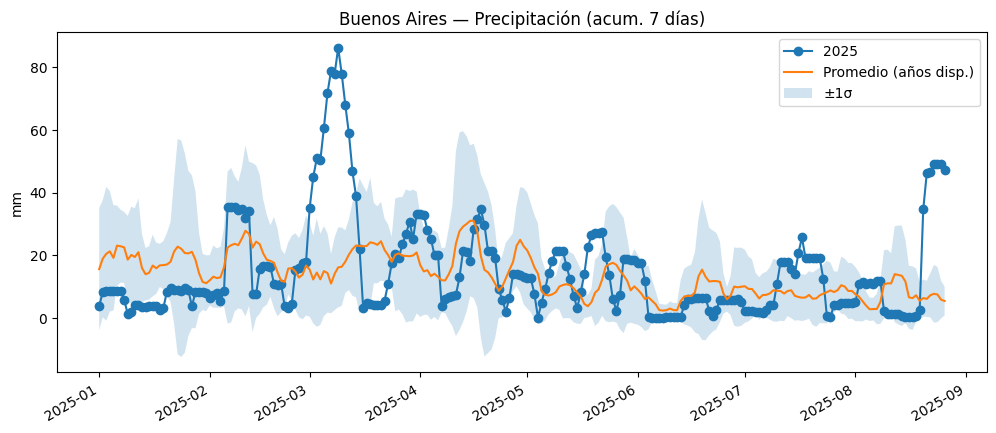

💾 Guardado: out_no_ee\plots\precip7_chaco.png


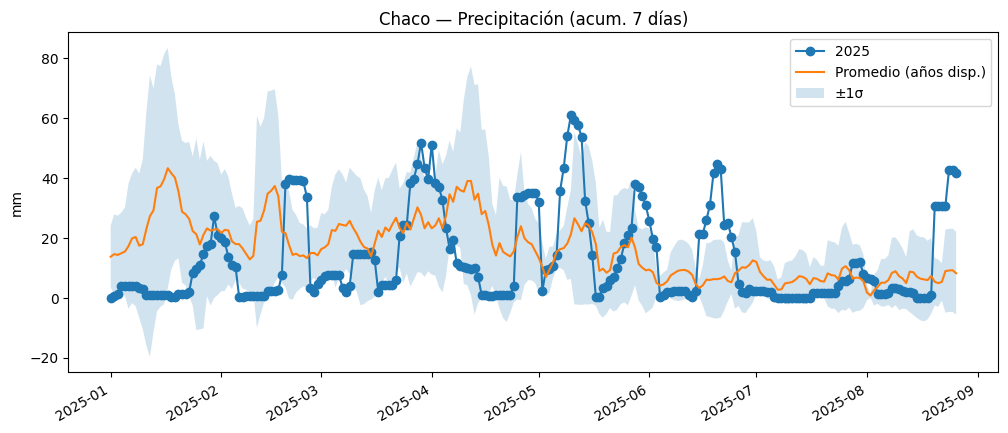

💾 Guardado: out_no_ee\plots\precip7_córdoba.png


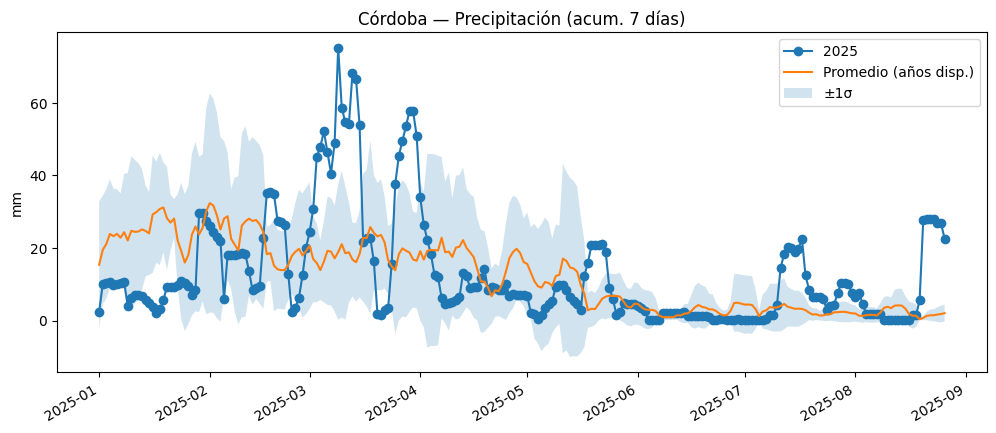

💾 Guardado: out_no_ee\plots\precip7_entre_ríos.png


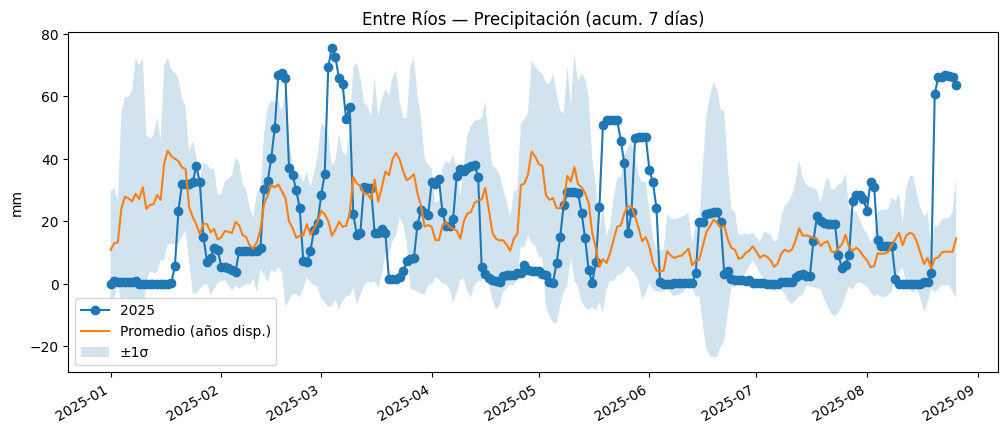

💾 Guardado: out_no_ee\plots\precip7_la_pampa.png


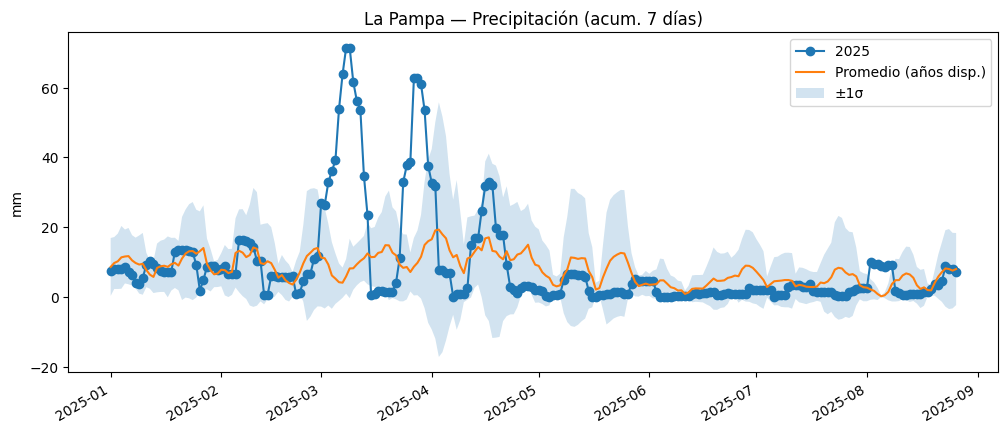

💾 Guardado: out_no_ee\plots\precip7_santa_fe.png


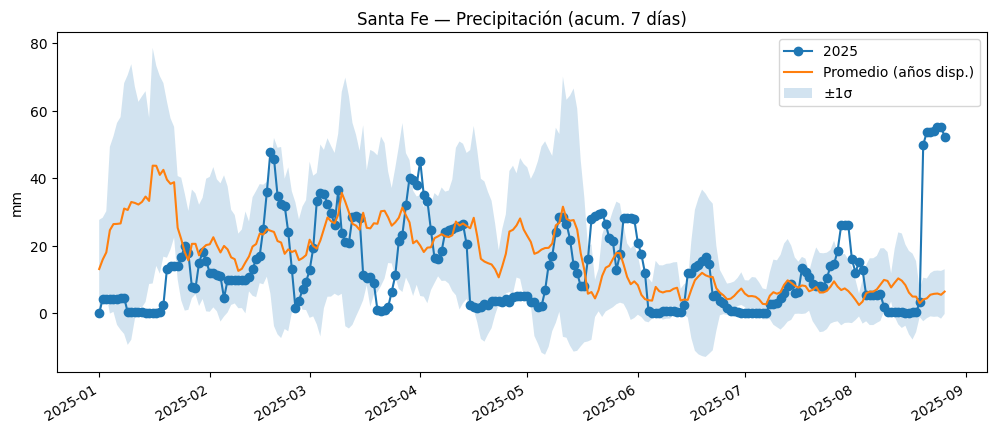

📊 Provincias detectadas: ['Buenos Aires', 'Chaco', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe']
💾 Guardado: out_no_ee\plots\t2m7_buenos_aires.png


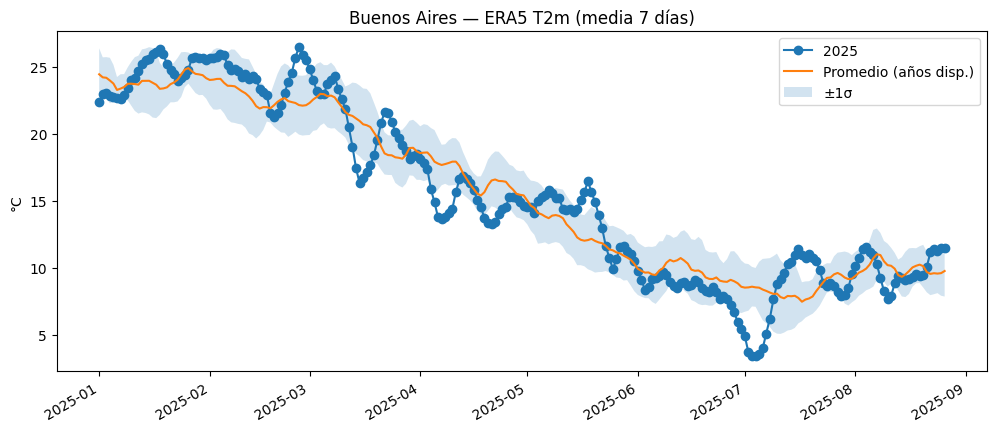

💾 Guardado: out_no_ee\plots\t2m7_chaco.png


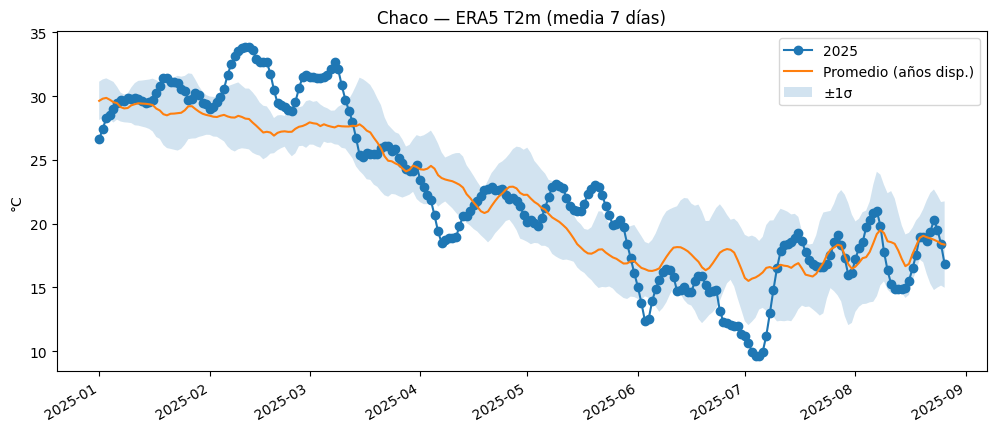

💾 Guardado: out_no_ee\plots\t2m7_córdoba.png


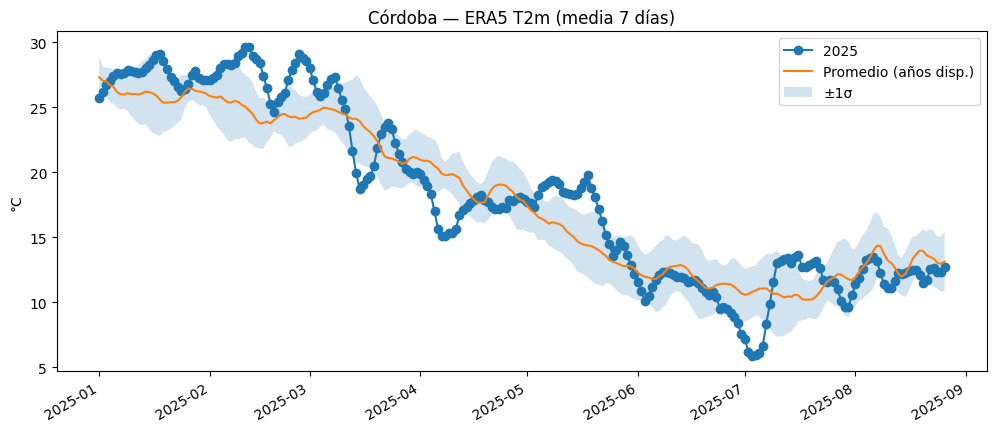

💾 Guardado: out_no_ee\plots\t2m7_entre_ríos.png


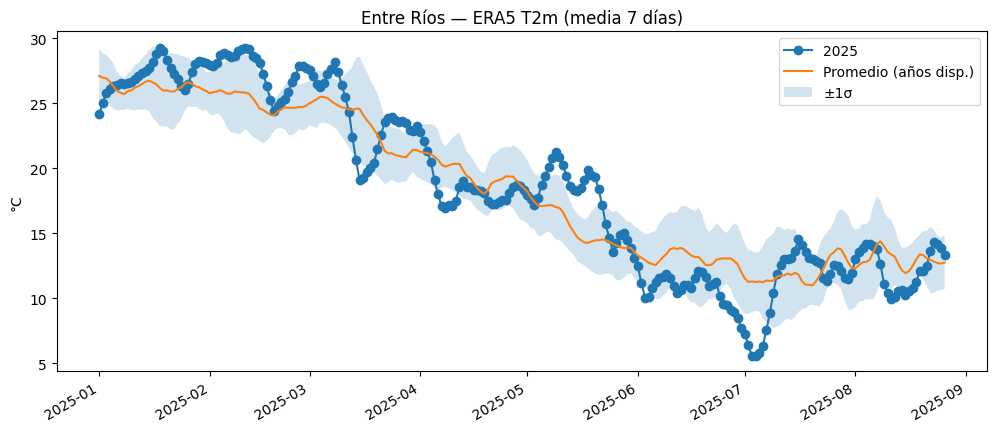

💾 Guardado: out_no_ee\plots\t2m7_la_pampa.png


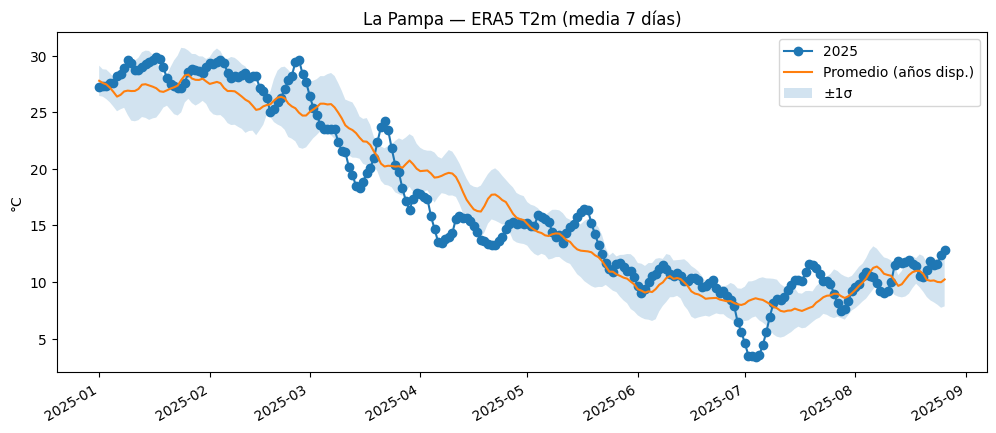

💾 Guardado: out_no_ee\plots\t2m7_santa_fe.png


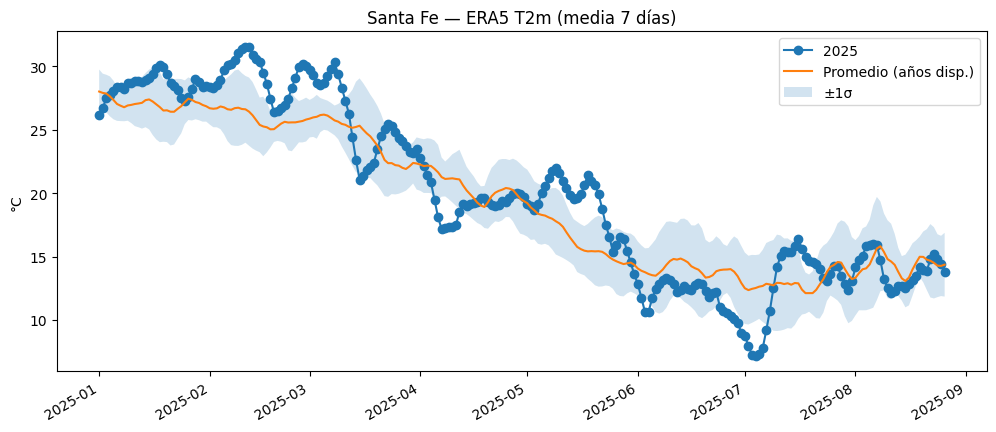

✅ Listo.


In [31]:
# -*- coding: utf-8 -*-
"""
Fix de CSV sin fechas + gráficos
- Repara columna 'date' si viene vacía (usa ayer como valor por defecto)
- Si hay 1 fecha -> gráficos de snapshot (barras por provincia)
- Si hay muchas fechas -> series temporales (con rolling y climatología si es posible)
"""

import os
from datetime import date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= CONFIG =========
CSV_IN     = os.path.join("out_no_ee", "meteo_2017_2025.csv")   # CSV original
CSV_FIXED  = os.path.join("out_no_ee", "meteo_2017_2025_fixed.csv")  # CSV corregido que vamos a escribir
PLOTS_DIR  = os.path.join("out_no_ee", "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Variables esperadas en tu CSV actual
VAR_TEMP   = "t2m_C"       # °C
VAR_PRECIP = "precip_mm"   # mm/día (o acumulación diaria)

# Parámetros de rolling / climatología
TARGET_YEAR = 2025
ROLL_CONFIG = [
    {"var":"precip_mm", "label":"Precipitación (acum. 7 días)", "unit":"mm", "mode":"sum",  "window":7, "slug":"precip7"},
    {"var":"t2m_C",     "label":"ERA5 T2m (media 7 días)",      "unit":"°C", "mode":"mean", "window":7, "slug":"t2m7"},
]

def read_csv_smart(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No encontré el CSV: {path}")
    # Intento autodetectar separador
    try:
        df = pd.read_csv(path, engine="python", sep=None, encoding="utf-8", low_memory=False)
        if df.shape[1] == 1:
            raise ValueError("Autodetección devolvió 1 columna; pruebo separadores comunes.")
    except Exception:
        df = None
    if df is None or df.shape[1] == 1:
        for sep in [",",";","\t","|"]:
            try:
                df2 = pd.read_csv(path, sep=sep, encoding="utf-8", low_memory=False)
                if df2.shape[1] > 1:
                    df = df2
                    break
            except Exception:
                pass
    if df is None:
        raise ValueError("No pude leer el CSV (separador desconocido).")

    # Normalización de columnas
    df.columns = [c.strip() for c in df.columns]
    if "province" not in df.columns:
        # intenta aliases básicos
        for alt in ["provincia","NAME_1","NAME_0"]:
            if alt in df.columns:
                df = df.rename(columns={alt:"province"})
                break
    if "province" not in df.columns:
        df["province"] = np.nan

    if "date" not in df.columns:
        df["date"] = np.nan

    return df

def fix_dates(df):
    df = df.copy()
    # Si todas las fechas están vacías/NaN, asigno AYER como fecha única
    if ("date" in df.columns) and (df["date"].isna().all() or (df["date"].astype(str).str.strip() == "").all()):
        assumed = (date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
        df["date"] = assumed
        print(f"🩹 'date' estaba vacío. Asigno fecha asumida: {assumed}")

    # Parseo a datetime
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    if df["date"].isna().all():
        # último recurso: si hay columnas year/month/day (no es el caso, pero lo contemplamos)
        for ycol in ["year","anio","año"]:
            if ycol in df.columns:
                year = pd.to_numeric(df[ycol], errors="coerce")
                month = pd.to_numeric(df.get("month", np.nan), errors="coerce")
                day = pd.to_numeric(df.get("day", np.nan), errors="coerce")
                df["date"] = pd.to_datetime(dict(year=year, month=month, day=day), errors="coerce")
                break
    return df

def compute_rolled(df, var, mode="mean", window=7):
    if var not in df.columns: 
        return pd.DataFrame(columns=["province","date","year","mmdd","value"])
    d = df[["province","date",var]].dropna().copy()
    if d.empty: 
        return pd.DataFrame(columns=["province","date","year","mmdd","value"])
    d = d.sort_values(["province","date"])
    if mode == "sum":
        d["value"] = d.groupby("province", as_index=False)[var].transform(lambda s: s.rolling(window, min_periods=1).sum())
    elif mode == "mean":
        d["value"] = d.groupby("province", as_index=False)[var].transform(lambda s: s.rolling(window, min_periods=1).mean())
    else:
        d["value"] = d[var]
    d["year"] = d["date"].dt.year
    d["mmdd"] = d["date"].dt.strftime("%m-%d")
    d = d[d["mmdd"] != "02-29"]
    return d

def compute_flexible_climatology(drolled, target_year):
    if drolled.empty: 
        return pd.DataFrame(columns=["province","mmdd","mean","std","count"])
    base = drolled[drolled["year"] != target_year]
    if base.empty:
        return pd.DataFrame(columns=["province","mmdd","mean","std","count"])
    clim = (base.groupby(["province","mmdd"])["value"]
            .agg(mean="mean", std="std", count="count")
            .reset_index())
    return clim[clim["count"] >= 3]

def plot_snapshot_bars(df, date_unique):
    """Si sólo hay una fecha: gráficos de barras por provincia para t2m_C y precip_mm."""
    d = df[df["date"] == date_unique].copy()
    provs = d["province"].fillna("N/A").tolist()
    # Temperatura
    if VAR_TEMP in d.columns and d[VAR_TEMP].notna().any():
        plt.figure(figsize=(12,5))
        plt.bar(provs, pd.to_numeric(d[VAR_TEMP], errors="coerce"))
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("°C")
        plt.title(f"T2m (°C) — {date_unique.date()}")
        out = os.path.join(PLOTS_DIR, f"snapshot_t2m_{date_unique.date()}.png")
        plt.savefig(out, bbox_inches="tight", dpi=140); plt.show()
        print("💾 Guardado:", out)
    else:
        print("ℹ️ No hay columna t2m_C con datos para snapshot.")

    # Precipitación
    if VAR_PRECIP in d.columns and d[VAR_PRECIP].notna().any():
        plt.figure(figsize=(12,5))
        plt.bar(provs, pd.to_numeric(d[VAR_PRECIP], errors="coerce"))
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("mm")
        plt.title(f"Precipitación diaria (mm) — {date_unique.date()}")
        out = os.path.join(PLOTS_DIR, f"snapshot_precip_{date_unique.date()}.png")
        plt.savefig(out, bbox_inches="tight", dpi=140); plt.show()
        print("💾 Guardado:", out)
    else:
        print("ℹ️ No hay columna precip_mm con datos para snapshot.")

def plot_series(df, var, label, unit, mode, window, slug):
    drolled = compute_rolled(df, var, mode, window)
    if drolled.empty:
        print(f"ℹ️ {var}: no hay datos (o todo NaN).")
        return
    clim = compute_flexible_climatology(drolled, TARGET_YEAR)
    provinces = sorted(df["province"].dropna().unique().tolist())
    print("📊 Provincias detectadas:", provinces)

    for prov in provinces:
        d_cur = drolled[(drolled["province"] == prov) & (drolled["year"] == TARGET_YEAR)].sort_values("date")
        if d_cur.empty:
            print(f"ℹ️ {var}: {prov} no tiene datos para {TARGET_YEAR}.")
            continue
        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(d_cur["date"], d_cur["value"], marker="o", label=str(TARGET_YEAR))

        if not clim.empty:
            cc = clim[clim["province"] == prov]
            if not cc.empty:
                m = d_cur.merge(cc, on=["province","mmdd"], how="left")
                ax.plot(m["date"], m["mean"], label="Promedio (años disp.)")
                if m["std"].notna().any():
                    ax.fill_between(m["date"], m["mean"] - m["std"], m["mean"] + m["std"], alpha=0.2, label="±1σ")

        ax.set_title(f"{prov} — {label}")
        ax.set_ylabel(unit)
        ax.legend()
        fig.autofmt_xdate()

        out = os.path.join(PLOTS_DIR, f"{slug}_{prov}.png".replace(" ", "_").lower())
        plt.savefig(out, bbox_inches="tight", dpi=140)
        print("💾 Guardado:", out)
        plt.show()

def main():
    # 1) Leer y arreglar fechas
    df = read_csv_smart(CSV_IN)
    df = fix_dates(df)

    # Guardar CSV corregido (te queda persistido con la fecha asumida)
    df_out = df.copy()
    # Asegurar tipos numéricos en las dos variables que vamos a graficar
    for c in [VAR_TEMP, VAR_PRECIP]:
        if c in df_out.columns:
            df_out[c] = pd.to_numeric(df_out[c], errors="coerce")
    df_out.to_csv(CSV_FIXED, index=False)
    print("✅ CSV corregido guardado en:", CSV_FIXED)

    # 2) ¿Cuántas fechas distintas hay?
    if df["date"].dropna().nunique() <= 1:
        # Snapshot (una sola fecha)
        unique_date = df["date"].dropna().iloc[0] if df["date"].notna().any() else (date.today() - timedelta(days=1))
        print(f"🖼️ Snapshot para {unique_date.date()} (1 fecha en el CSV).")
        plot_snapshot_bars(df, pd.to_datetime(unique_date))
        return

    # 3) Series temporales (si hay varias fechas)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    for cfg in ROLL_CONFIG:
        if cfg["var"] not in df.columns:
            print(f"ℹ️ Omito {cfg['var']}: no está en el CSV.")
            continue
        plot_series(df, cfg["var"], cfg["label"], cfg["unit"], cfg["mode"], cfg["window"], cfg["slug"])

    print("✅ Listo.")

if __name__ == "__main__":
    main()
